#Trend Analysis - Agritech Domain
- **Descrizione**: L'obiettivo principale di questa iniziativa è sviluppare un modello predittivo in grado di stimare con precisione il numero di insetti catturati da una o più trappole, utilizzando dati ambientali giornalieri relativi alla temperatura e all'umidità.

- **Dati**: Il dataset fornito è suddiviso in più file Excel, ciascuno dei quali contiene i dati raccolti da sensori installati nelle città di Imola e Cicalino.

- **Task**:
  1.   *Regressione* : prevedere il numero totale di insetti catturati in un determinato periodo
  2.   *Classificazione* : identificazione della presenza di nuove catture in un determinato periodo



Per i motivi descritti nella documentazione allegata, si è scelto di trattare il problema separatamente per le due città



#Operazioni preliminari

In [ ]:
#@title Import Librerie
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from scipy.stats import kstest, ks_2samp
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns
import os
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy.stats import kstest, ks_2samp
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.tsa.stattools import pacf
import ipywidgets as widgets
from IPython.display import display, clear_output
from ipywidgets import VBox


from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score


from scipy.stats import gaussian_kde

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

In [ ]:
#@title Definizione Funzioni per la Visualizzazione

def advanced_time_series_analysis(df, column, lags=40, period=None):
    # Ensure the time series is a pandas Series and check for a datetime index
    time_series = df[column]

    # If period is not set, and you need to automate:
    # You might want to specify this manually or adjust according to your data's known seasonality
    if period is None:
        period = 12  # Example for monthly data with an assumed annual cycle

    fig, axs = plt.subplots(2, 2, figsize=(18, 12))

    # Plot ACF
    plot_acf(time_series, ax=axs[0, 0], lags=lags, zero=False)
    axs[0, 0].set_title('Autocorrelation Function')

    # Plot PACF
    plot_pacf(time_series, ax=axs[0, 1], lags=lags, zero=False, method='ols')
    axs[0, 1].set_title('Partial Autocorrelation Function')

    # Seasonal Decomposition
    result = seasonal_decompose(time_series.dropna(), model='additive', period=period)
    axs[1, 0].plot(result.trend, label='Trend')
    axs[1, 0].plot(result.seasonal, label='Seasonal', alpha=0.6)
    axs[1, 0].plot(result.resid, label='Residual', alpha=0.6)
    axs[1, 0].legend()
    axs[1, 0].set_title('Seasonal Decomposition')

    # Simple Line Plot of the Time Series
    axs[1, 1].plot(time_series.index, time_series, label='Raw Data')
    axs[1, 1].set_title('Time Series Plot')
    axs[1, 1].set_xlabel('Time')
    axs[1, 1].set_ylabel('Value')
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()
def plot_line_and_distribution(dfs, date_col, figsize=(18, 10)):
    """
    Plots line graphs and distribution plots of common columns in the given dataframes.
    The graphs are plotted in a 2x2 grid, with line plots on the top row and distribution plots on the bottom row.

    Parameters:
    dfs (list): List of pandas DataFrames.
    date_col (str): Name of the column containing the date.
    figsize (tuple): Size of the figure (width, height).
    """

    # Convert the date column to datetime in all dataframes and set it as index
    for df in dfs:
        if date_col in df.columns:
            df[date_col] = pd.to_datetime(df[date_col])
            df.set_index(date_col, inplace=True)

    # Find common columns in all dataframes
    common_columns = set(dfs[0].columns)
    for df in dfs[1:]:
        common_columns.intersection_update(df.columns)

    # If there are no common columns or less than 2, return
    if not common_columns:
        print("No common columns to plot.")
        return
    if len(common_columns) < 2:
        print("Not enough common columns to create a 2x2 grid.")
        return

    # Select the first two common columns for plotting
    selected_columns = list(common_columns)[:2]

    # Create figure and axes for a 2x2 grid
    fig, axs = plt.subplots(2, 2, figsize=figsize)

    # Plot line plots and distribution plots
    for i, col in enumerate(selected_columns):
        # Line plot
        ax_line = axs[0, i]
        for df in dfs:
            sns.lineplot(data=df, x=df.index, y=col, ax=ax_line)
        ax_line.set_title(f'Lineplot of {col}')
        ax_line.legend([f'DF{i+1}' for i in range(len(dfs))])
        ax_line.grid(True)

        # Distribution plot
        ax_dist = axs[1, i]
        for df in dfs:
            sns.histplot(df[col], kde=True, ax=ax_dist)
        ax_dist.set_title(f'Distribution of {col}')

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

def max_correlation_matrix_with_type(df):
    # Calculate different types of correlations
    pearson_corr = df.corr(method='pearson')
    spearman_corr = df.corr(method='spearman')
    kendall_corr = df.corr(method='kendall')

    # Initialize the maximum correlation matrix and type matrix
    max_corr = pearson_corr.copy()
    corr_type = pd.DataFrame(index=pearson_corr.index, columns=pearson_corr.columns)

    # Determine the maximum correlation and its type
    for row in pearson_corr.index:
        for col in pearson_corr.columns:
            max_value = max(pearson_corr.at[row, col], spearman_corr.at[row, col], kendall_corr.at[row, col])
            max_corr.at[row, col] = max_value
            if max_value == pearson_corr.at[row, col]:
                corr_type.at[row, col] = 'p'
            elif max_value == spearman_corr.at[row, col]:
                corr_type.at[row, col] = 's'
            else:
                corr_type.at[row, col] = 'k'

    return max_corr, corr_type

def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

def create_grid_visualizations(df):
    numeric_df = df.select_dtypes(include=[np.number])

    fig, axs = plt.subplots(2, 2, figsize=(18, 12))

    # Violin plots for all numeric columns
    sns.violinplot(data=numeric_df, ax=axs[0, 0])
    axs[0, 0].set_title('Violin plots of numeric columns')
    axs[0, 0].grid(True)

    # Maximum Correlation Matrix with type annotations
    max_corr, corr_type = max_correlation_matrix_with_type(numeric_df)
    annot = np.array([['{:.2f} ({})'.format(max_corr.iloc[i, j], corr_type.iloc[i, j]) for j in range(len(max_corr.columns))] for i in range(len(max_corr))])
    sns.heatmap(max_corr, annot=annot, cmap='coolwarm', fmt='', linewidths=.5, ax=axs[0, 1])
    axs[0, 1].set_title('Maximum Correlation Matrix with Type')

    # Variance Inflation Factor (VIF)
    vif_data = calculate_vif(numeric_df)
    vif_colors = ['darkred' if x > 10 else 'red' if x > 5 else 'green' for x in vif_data['VIF']]
    bars = sns.barplot(x='feature', y='VIF', data=vif_data, palette=vif_colors, ax=axs[1, 0])
    axs[1, 0].axhline(10, color='black', linestyle='--')
    axs[1, 0].set_title('Variance Inflation Factor (VIF)')
    axs[1, 0].set_xticklabels(vif_data['feature'], rotation=45)
    # Annotating multicollinearity threshold
    for bar in bars.patches:
        if bar.get_width() > 10:
            bar.set_color('darkred')
        elif bar.get_width() > 5:
            bar.set_color('red')

    # Cumulative Distribution Plot for all numeric columns
    for column in numeric_df.columns:
        sns.ecdfplot(numeric_df[column], ax=axs[1, 1], label=f'{column} ECDF')
    axs[1, 1].set_title('Cumulative Distribution Function (CDF) for all numeric columns')
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

def advanced_time_series_analysis(df, column, lags=40, period=None):
    # Ensure the time series is a pandas Series and check for a datetime index
    time_series = df[column]

    # If period is not set, and you need to automate:
    # You might want to specify this manually or adjust according to your data's known seasonality
    if period is None:
        period = 12  # Example for monthly data with an assumed annual cycle

    fig, axs = plt.subplots(2, 2, figsize=(18, 12))

    # Plot ACF
    plot_acf(time_series, ax=axs[0, 0], lags=lags, zero=False)
    axs[0, 0].set_title('Autocorrelation Function')

    # Plot PACF
    plot_pacf(time_series, ax=axs[0, 1], lags=lags, zero=False, method='ols')
    axs[0, 1].set_title('Partial Autocorrelation Function')

    # Seasonal Decomposition
    result = seasonal_decompose(time_series.dropna(), model='additive', period=period)
    axs[1, 0].plot(result.trend, label='Trend')
    axs[1, 0].plot(result.seasonal, label='Seasonal', alpha=0.6)
    axs[1, 0].plot(result.resid, label='Residual', alpha=0.6)
    axs[1, 0].legend()
    axs[1, 0].set_title('Seasonal Decomposition')

    # Simple Line Plot of the Time Series
    axs[1, 1].plot(time_series.index, time_series, label='Raw Data')
    axs[1, 1].set_title('Time Series Plot')
    axs[1, 1].set_xlabel('Time')
    axs[1, 1].set_ylabel('Value')
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()


# Funzione per aggiornare i grafici
def update_plots(column, k, nlags):
    """
    Aggiorna i grafici basandosi sul dataset df_finale e i parametri selezionati.

    Args:
        column (str): Nome della colonna da utilizzare come serie temporale.
        k (int): Dimensione della finestra per la media mobile.
        nlags (int): Numero massimo di lag per il calcolo della PACF.
    """
    # Carica la serie temporale dal dataset
    series = df_finale_regressione[column].dropna()

    # Calcolo della media mobile con finestra k
    rolling_mean = series.rolling(window=k).mean()

    # Test di Shapiro-Wilk per Gaussianità
    stat, p_value = stats.shapiro(series)
    is_gaussian = p_value > 0.05
    gaussian_text = 'Gaussian' if is_gaussian else 'Non-Gaussian'

    # Calcolo della Partial Autocorrelation Function (PACF)
    pacf_values = pacf(series, nlags=nlags, method='ols')[1:]  # Escludi lag 0
    lags = np.arange(1, len(pacf_values) + 1)  # Crea i lag corrispondenti ai valori PACF

    # Determinazione della markovianità basata su una soglia della PACF
    threshold = 0.15
    significant_pacf = np.abs(pacf_values) > threshold
    markovian_text = 'Non-Markovian' if np.any(significant_pacf) else 'Markovian'

    # Pulizia output precedente
    clear_output(wait=True)

    # Creazione della figura con 2x2 subplot
    fig, axs = plt.subplots(2, 2, figsize=(14, 7))

    # Time Series Plot con Media Mobile
    axs[0, 0].plot(series.index, series.values, color='blue', label='Time Series')
    axs[0, 0].plot(rolling_mean.index, rolling_mean.values, color='orange', label=f'Rolling Mean (k={k})')
    axs[0, 0].set_title('Time Series Plot with Rolling Mean')
    axs[0, 0].set_xlabel('Time')
    axs[0, 0].set_ylabel('Value')
    axs[0, 0].grid(True)
    axs[0, 0].legend()

    # QQ Plot per verificare la Gaussianità
    stats.probplot(series, dist="norm", plot=axs[0, 1])
    axs[0, 1].set_title('QQ Plot of Time Series')
    axs[0, 1].set_xlabel('Theoretical Quantiles')
    axs[0, 1].set_ylabel('Sample Quantiles')
    axs[0, 1].grid(True)
    axs[0, 1].text(
        0.05, 0.90, f'Time Series is {gaussian_text}',
        transform=axs[0, 1].transAxes,
        fontsize=12, verticalalignment='top',
        bbox=dict(facecolor='white', alpha=0.8)
    )

    # Partial Autocorrelation Plot
    axs[1, 0].bar(lags, pacf_values, width=0.7, color='skyblue', label='Partial Autocorrelation')
    axs[1, 0].axhline(y=threshold, color='red', linestyle='--', label=f'Threshold = ±{threshold}')
    axs[1, 0].axhline(y=-threshold, color='red', linestyle='--')
    axs[1, 0].set_title('Partial Autocorrelation Plot')
    axs[1, 0].set_xlabel('Lag')
    axs[1, 0].set_ylabel('Partial Autocorrelation')
    axs[1, 0].grid(True)
    axs[1, 0].text(
        0.05, 0.90, f'Time Series is {markovian_text}',
        transform=axs[1, 0].transAxes,
        fontsize=12, verticalalignment='top',
        bbox=dict(facecolor='white', alpha=0.8)
    )

    # Histogram della Serie Temporale
    axs[1, 1].hist(series, bins=30, color='lightblue', edgecolor='black', alpha=0.7)
    axs[1, 1].set_title('Histogram of Time Series Values')
    axs[1, 1].set_xlabel('Value')
    axs[1, 1].set_ylabel('Frequency')
    axs[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

    # Visualizzazione widget per interazioni
    display(widget_box)

In [ ]:
#@title Conversione HTML -> CSV
import os
from bs4 import BeautifulSoup

def extract_table_data_and_save_as_csv(html_file, csv_file):
    """Estrae e salva i dati della tabella da un file HTML in un file CSV."""
    with open(html_file, 'r') as f:
        soup = BeautifulSoup(f, 'html.parser')

    # Trova la tabella
    table = soup.find('table')

    # Estrai le righe della tabella
    rows = table.find_all('tr')

    # Lista per memorizzare i dati della tabella
    data = []

    # Estrazione delle righe e creazione dei dati
    for row in rows:
        cols = row.find_all(['th', 'td'])  # Estrai le celle di intestazione e dati
        cols = [ele.text.strip() for ele in cols]  # Estrai solo il testo
        data.append(cols)

    # Il DataFrame è creato a partire dalle righe estratte
    df = pd.DataFrame(data)

    # Se la tabella ha almeno 2 righe (le intestazioni)
    if len(df) > 1:
        # Rinomina le colonne in base alla struttura della tabella
        df.columns = ['DateTime', 'Media Temperatura', 'Temperatura Intervallo Low', 'Temperatura Intervallo High', 'Media Umidità']

        # Rimuovi la prima riga che contiene i nomi delle colonne (duplicati)
        df = df[1:]

        # Mantieni i valori come stringhe (senza conversioni in numerico)
        df['Temperatura Intervallo Low'] = df['Temperatura Intervallo Low'].str.replace(',', '.')
        df['Temperatura Intervallo High'] = df['Temperatura Intervallo High'].str.replace(',', '.')
        df['Media Temperatura'] = df['Media Temperatura'].str.replace(',', '.')
        df['Media Umidità'] = df['Media Umidità'].str.replace(',', '.')

        # Non fare la conversione della colonna DateTime, ma mantienila come stringa
        df['DateTime'] = df['DateTime'].astype(str)

        # Salva il DataFrame come CSV
        df.to_csv(csv_file, index=False)
        print(f"File salvato come {csv_file}")
    else:
        print(f"Nessun dato trovato nella tabella di {html_file}")

def process_all_xls_in_folder(folder_path, output_folder):
    """Processa tutti i file .xls nella cartella specificata e li converte in CSV."""
    for filename in os.listdir(folder_path):
        if filename.endswith('.xls'):
            html_file = os.path.join(folder_path, filename)
            csv_file = os.path.join(output_folder, filename.replace('.xls', '.csv'))
            extract_table_data_and_save_as_csv(html_file, csv_file)

# Percorso della cartella contenente i file .xls
folder_path = '/content'  # Modifica con il percorso della cartella
output_folder = '/content/csv_output'  # Modifica con la cartella di destinazione dei file CSV

# Assicurati che la cartella di output esista
os.makedirs(output_folder, exist_ok=True)

# Elabora tutti i file .xls nella cartella
process_all_xls_in_folder(folder_path, output_folder)
import pandas as pd
import os

# Percorso della cartella che contiene i file CSV
folder_path = "/content/csv_output"

# Itera su tutti i file CSV nella cartella
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv') and file_name.startswith('dati-meteo'):  # Controlla solo i file CSV
        file_path = os.path.join(folder_path, file_name)

        # Leggi il file CSV
        df = pd.read_csv(file_path)

        # Controlla se il DataFrame ha almeno 2 righe
        if len(df) > 1:
            # Elimina la prima riga
            df = df.drop(index=0)

        # Salva il DataFrame modificato nel file CSV
        df.to_csv(file_path, index=False)

        print(f"Prima riga eliminata in: {file_name}")
    if file_name.endswith('.csv') and file_name.startswith('grafico-delle-catture'):  # Controlla solo i file CSV
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path)
        df.rename(columns={'Media Temperatura': 'Numero di insetti',
                        'Temperatura Intervallo Low': 'Nuove catture (per evento)',
                        'Temperatura Intervallo High': 'Recensito',
                        'Media Umidità': 'Evento'}, inplace=True)
        df.to_csv(file_path, index=False)
        print(f"Salvato: {file_name}")
print("Completato")

File salvato come /content/csv_output/dati-meteo-storici (Imola 1).csv
File salvato come /content/csv_output/grafico-delle-catture (Imola 1).csv
File salvato come /content/csv_output/dati-meteo-storici (Cicalino 2).csv
File salvato come /content/csv_output/grafico-delle-catture (Cicalino 1).csv
File salvato come /content/csv_output/dati-meteo-storici (Imola 3).csv
File salvato come /content/csv_output/dati-meteo-storici (Cicalino 1).csv
File salvato come /content/csv_output/grafico-delle-catture (Cicalino 2).csv
File salvato come /content/csv_output/grafico-delle-catture (Imola 2).csv
File salvato come /content/csv_output/dati-meteo-storici (Imola 2).csv
File salvato come /content/csv_output/grafico-delle-catture (Imola 3).csv
Salvato: grafico-delle-catture (Imola 1).csv
Prima riga eliminata in: dati-meteo-storici (Cicalino 1).csv
Prima riga eliminata in: dati-meteo-storici (Cicalino 2).csv
Prima riga eliminata in: dati-meteo-storici (Imola 3).csv
Prima riga eliminata in: dati-meteo-st

In [ ]:
#@title Lettura file
file_path = '/content/csv_output'

#Lettura dati meteo
df_1 = pd.read_csv(os.path.join(file_path, 'dati-meteo-storici (Imola 1).csv'))
df_2 = pd.read_csv(os.path.join(file_path, 'dati-meteo-storici (Imola 2).csv'))
df_3 = pd.read_csv(os.path.join(file_path, 'dati-meteo-storici (Imola 3).csv'))

#Lettura dati catture
df_ca_1 = pd.read_csv(os.path.join(file_path, 'grafico-delle-catture (Imola 1).csv'))
df_ca_2 = pd.read_csv(os.path.join(file_path, 'grafico-delle-catture (Imola 2).csv'))
df_ca_3 = pd.read_csv(os.path.join(file_path, 'grafico-delle-catture (Imola 3).csv'))




In [ ]:
#@title Data Prepocessing: Cambio indice

#Cambio dell'indice da un valore numerico predefinito alla data
#@title Data Prepocessing: Cambio indice
df_1.index = df_1.DateTime
df_1.index = pd.to_datetime(df_1.index, format="%d.%m.%Y %H:%M:%S")
df_1.index = df_1.index.strftime('%Y-%m-%d %H:%M:%S')
del df_1["DateTime"]
df_1.head(1)

df_2.index = df_2.DateTime
df_2.index = pd.to_datetime(df_2.index, format="%d.%m.%Y %H:%M:%S")
df_2.index = df_2.index.strftime('%Y-%m-%d %H:%M:%S')
del df_2["DateTime"]
df_2.head(1)

df_3.index = df_3.DateTime
df_3.index = pd.to_datetime(df_3.index, format="%d.%m.%Y %H:%M:%S")
df_3.index = df_3.index.strftime('%Y-%m-%d %H:%M:%S')
del df_3["DateTime"]

df_ca_1.index = df_ca_1.DateTime
df_ca_1.index = pd.to_datetime(df_ca_1.index, format="%d.%m.%Y %H:%M:%S")
df_ca_1.index = df_ca_1.index.strftime('%Y-%m-%d %H:%M:%S')
del df_ca_1["DateTime"]
df_ca_1.head(1)

df_ca_2.index = df_ca_2.DateTime
df_ca_2.index = pd.to_datetime(df_ca_2.index, format="%d.%m.%Y %H:%M:%S")
df_ca_2.index = df_ca_2.index.strftime('%Y-%m-%d %H:%M:%S')
del df_ca_2["DateTime"]
df_ca_1.head(2)

df_ca_3.index = df_ca_3.DateTime
df_ca_3.index = pd.to_datetime(df_ca_3.index, format="%d.%m.%Y %H:%M:%S")
df_ca_3.index = df_ca_3.index.strftime('%Y-%m-%d %H:%M:%S')
del df_ca_3["DateTime"]
df_ca_3.head(1)

,Numero di insetti,Nuove catture (per evento),Recensito,Evento
DateTime,,,,
2024-08-17 00:02:00,0,0,Si,NaN


#Analisi Preliminare Dati Meteo

I file rappresentano l'output di sensori differenti. Effettuiamo uno studio preliminare per capire come gestire le informazioni in essi contenute.

In [ ]:
#@title Informazioni principali dalle tabelle
print("Dati Imola 1: ")
print(df_1.describe())
print(df_1.info())
print("--------------------------------\n")
print("Dati Imola 2: ")
print(df_2.describe())
print(df_2.info())
print("--------------------------------\n")
print("Dati Imola 3: ")
print(df_3.describe())
print(df_3.info())
print("--------------------------------\n")
print("Dati Grafico Imola 1: ")
print(df_ca_1.describe())
print(df_ca_1.info())
print("--------------------------------\n")
print("Dati Grafico Imola 2: ")
print(df_ca_2.describe())
print(df_ca_2.info())
print("--------------------------------\n")
print("Dati Grafico Imola 3: ")
print(df_ca_3.describe())
print(df_ca_3.info())
print("--------------------------------\n")

Dati Imola 1: 
       Media Temperatura  Temperatura Intervallo Low  \
count         564.000000                  564.000000   
mean           27.548936                   26.844149   
std             5.607029                    5.485856   
min            17.860000                   17.600000   
25%            22.897500                   22.400000   
50%            26.020000                   25.300000   
75%            32.565000                   31.725000   
max            39.820000                   39.600000   

       Temperatura Intervallo High  Media Umidità  
count                   564.000000     564.000000  
mean                     28.273759      61.987500  
std                       5.743532      19.229186  
min                      18.200000      24.070000  
25%                      23.375000      44.235000  
50%                      26.900000      63.380000  
75%                      33.400000      77.232500  
max                      40.100000      99.350000  
<class 'pand

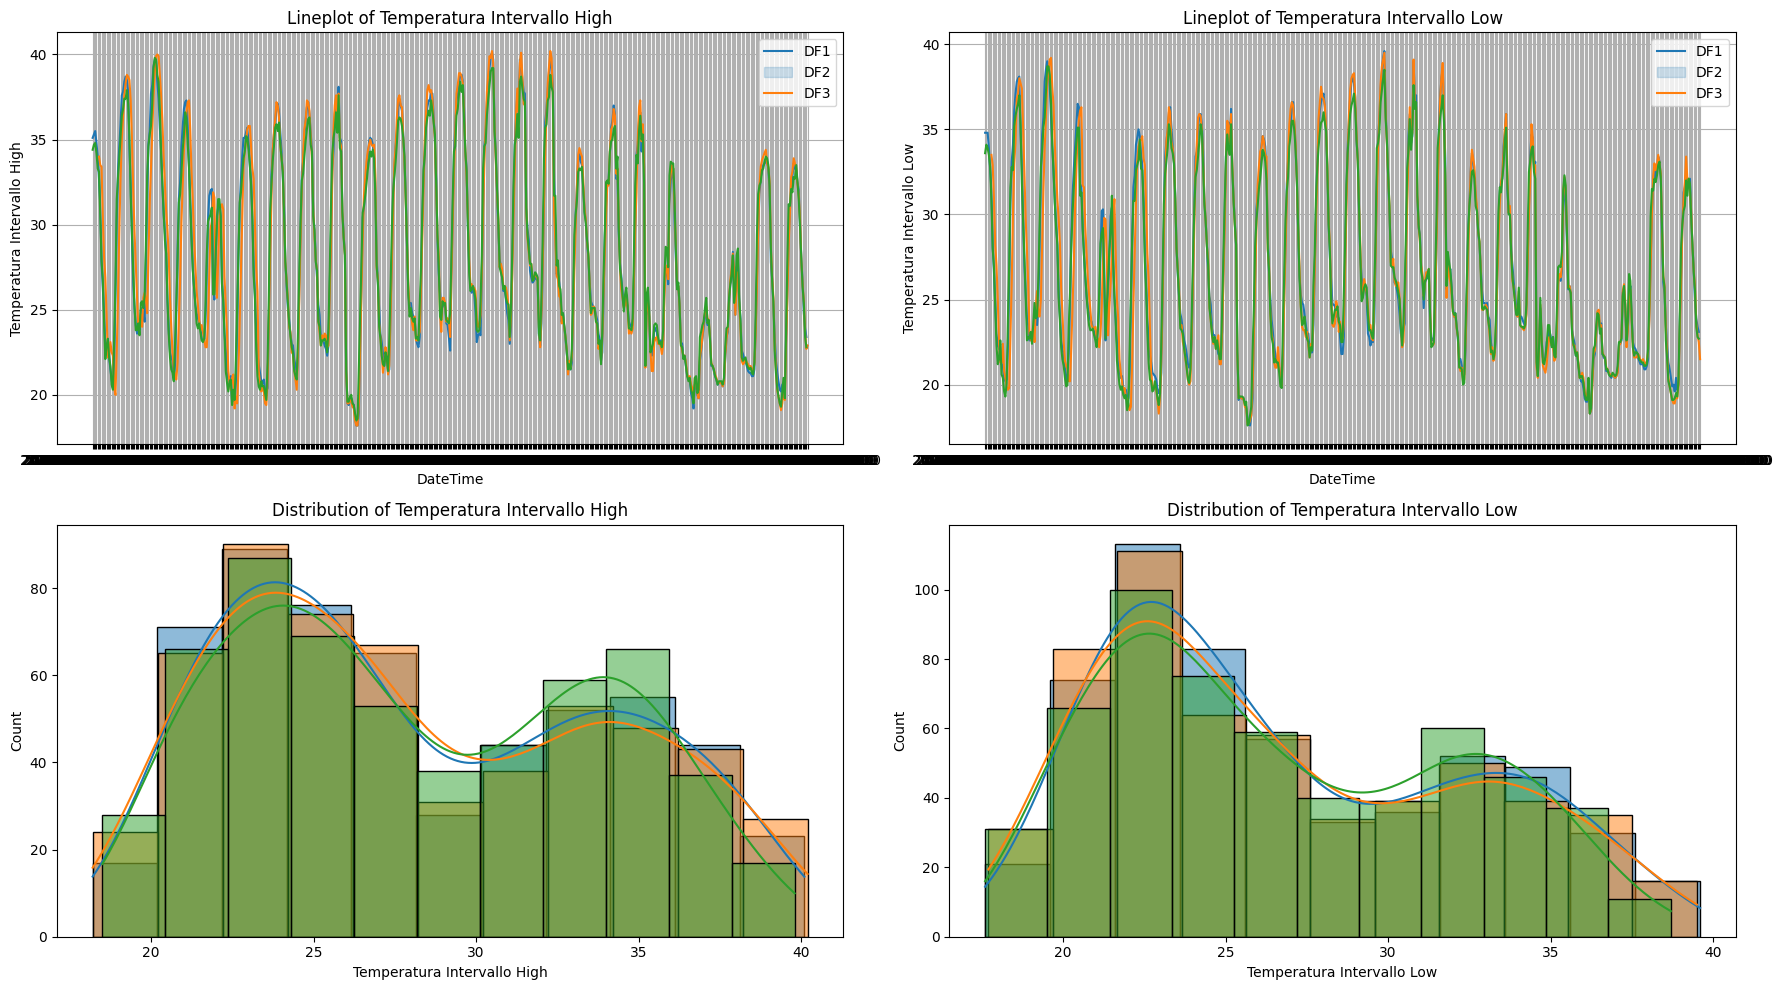

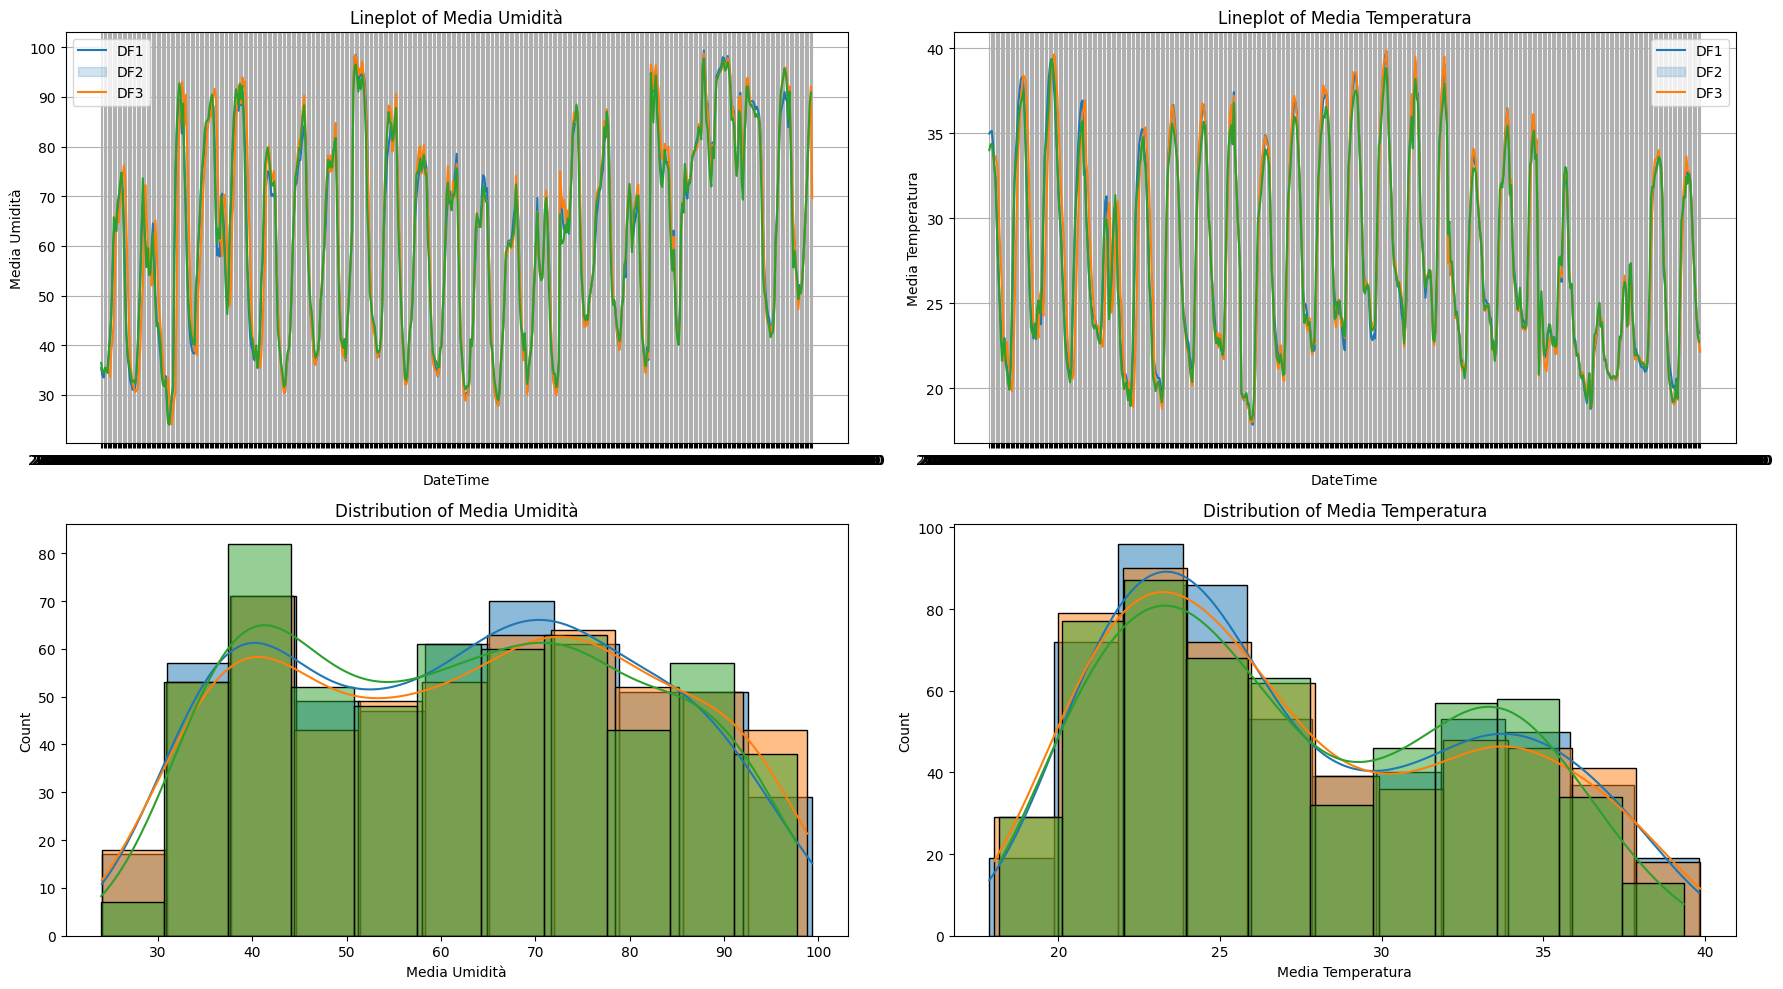

In [ ]:
#@title Confronto dei tre dataset di meteo

#Visualizziamo le distribuzione dei vari attributi, per capire di quanto differiscono tra di loro


#Visualizzazione Temperatura più bassa e più altra misurata
column_names2 = ['Temperatura Intervallo Low', 'Temperatura Intervallo High']
plot_line_and_distribution([df_1[column_names2], df_2[column_names2], df_3[column_names2]], 'DateTime')


column_names = ['Media Temperatura', 'Media Umidità']
plot_line_and_distribution([df_1[column_names], df_2[column_names], df_3[column_names]], 'DateTime')


In [ ]:
#@title Unione dataset 1 e 2

# Si uniscono solo i dataset 1 e 2 avendo molti più giorni in comune sulle catture
# Il terzo dataset viene utilizzato come dataset di test avendo a disposizione pochi dati sui giorni delle catture

df_1 = df_1.apply(pd.to_numeric, errors='coerce')
df_2 = df_2.apply(pd.to_numeric, errors='coerce')

# Trova gli indici comuni e non comuni tra i due dataset
indici_comuni = df_1.index.intersection(df_2.index)
indici_non_comuni_df_1 = df_1.index.difference(df_2.index)
indici_non_comuni_df_2 = df_2.index.difference(df_1.index)

# Calcola la media per gli indici comuni
media_comuni = pd.DataFrame({
    col: (
        pd.to_numeric(df_1.loc[indici_comuni, col], errors='coerce') +
        pd.to_numeric(df_2.loc[indici_comuni, col], errors='coerce')
    ) / 2
    for col in df_1.columns
}, index=indici_comuni)

# Per gli indici non comuni, prendi i dati originali
righe_non_comuni_df_1 = df_1.loc[indici_non_comuni_df_1]
righe_non_comuni_df_2 = df_2.loc[indici_non_comuni_df_2]

# Combina i dati per gli indici comuni e non comuni
dataset_completo = pd.concat([
    media_comuni,
    righe_non_comuni_df_1,
    righe_non_comuni_df_2
])

# Assicurati che l'indice sia in formato datetime
dataset_completo.index = pd.to_datetime(dataset_completo.index, format="%Y-%m-%d %H:%M:%S")

# Ordina il DataFrame per indice datetime
df_meteo_completo = dataset_completo.sort_index()

#Arrotondo a tre cifre i dati ricevuti
df_meteo_completo = df_meteo_completo.round(3)
df_3 = df_3.round(3)

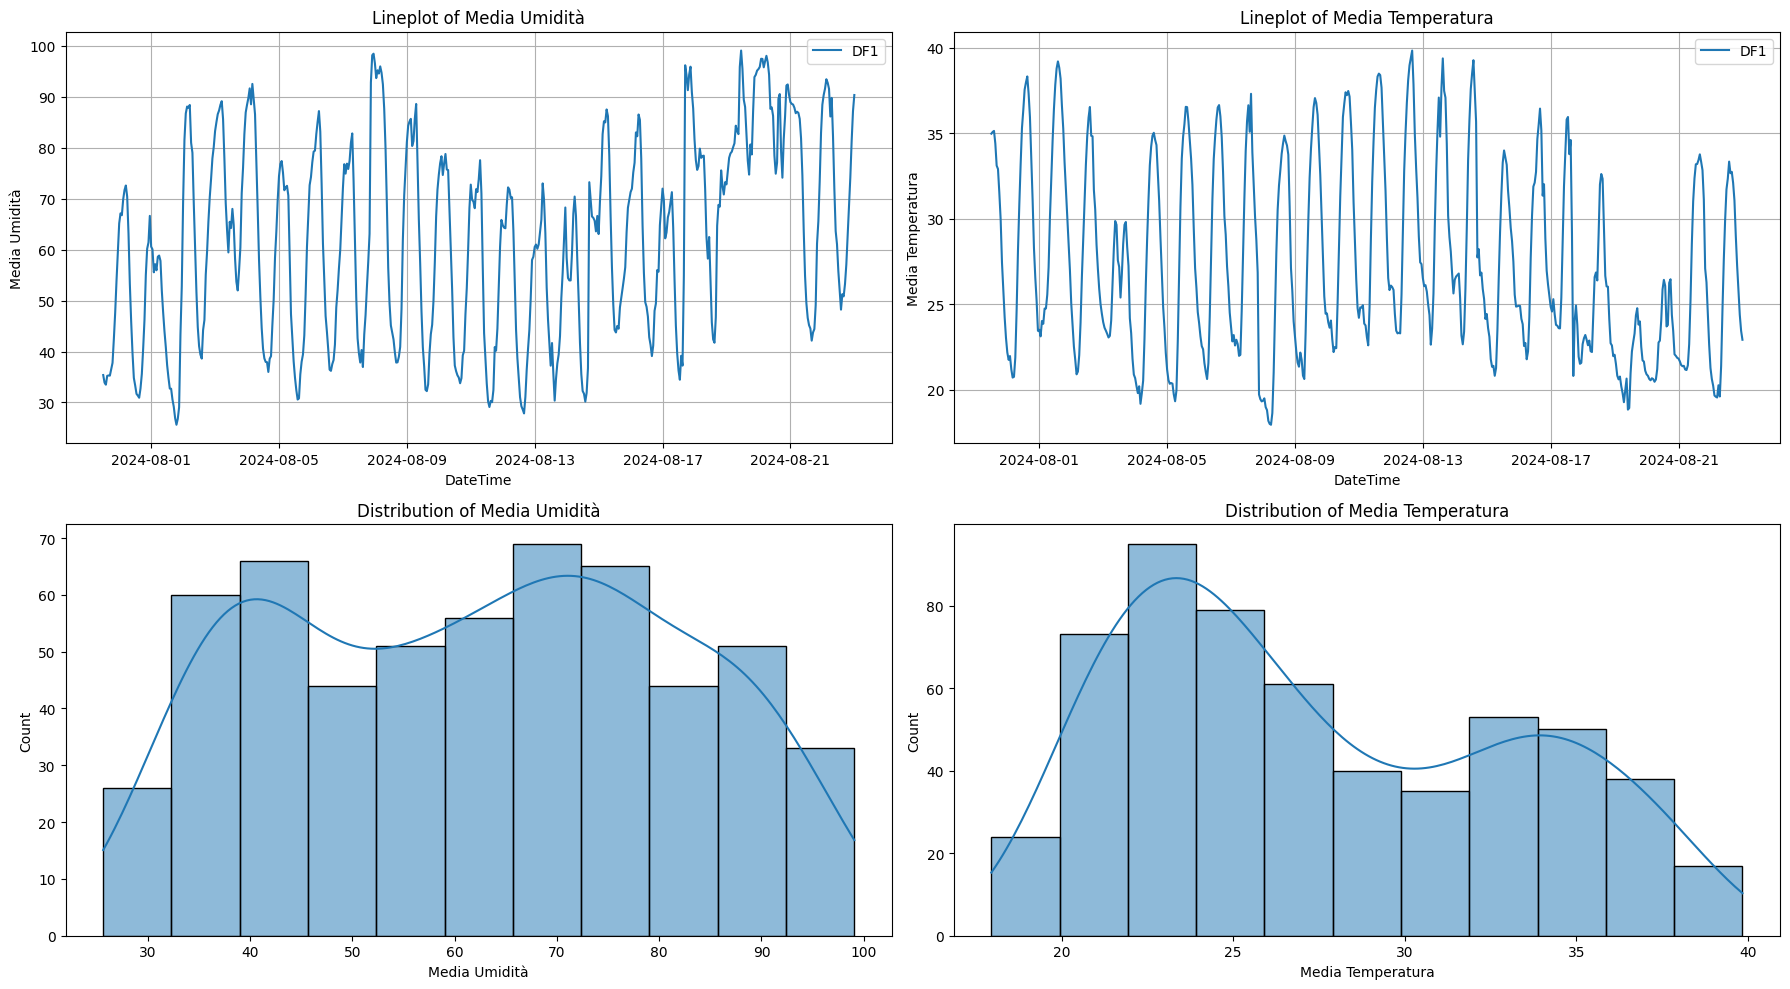

In [ ]:
#@title Data Visualization -  Investigazione dei dati dopo l'unione (Media Umidità e Media Temperatura)

column_names = ['Media Temperatura', 'Media Umidità']
plot_line_and_distribution([df_meteo_completo[column_names]], 'DateTime')


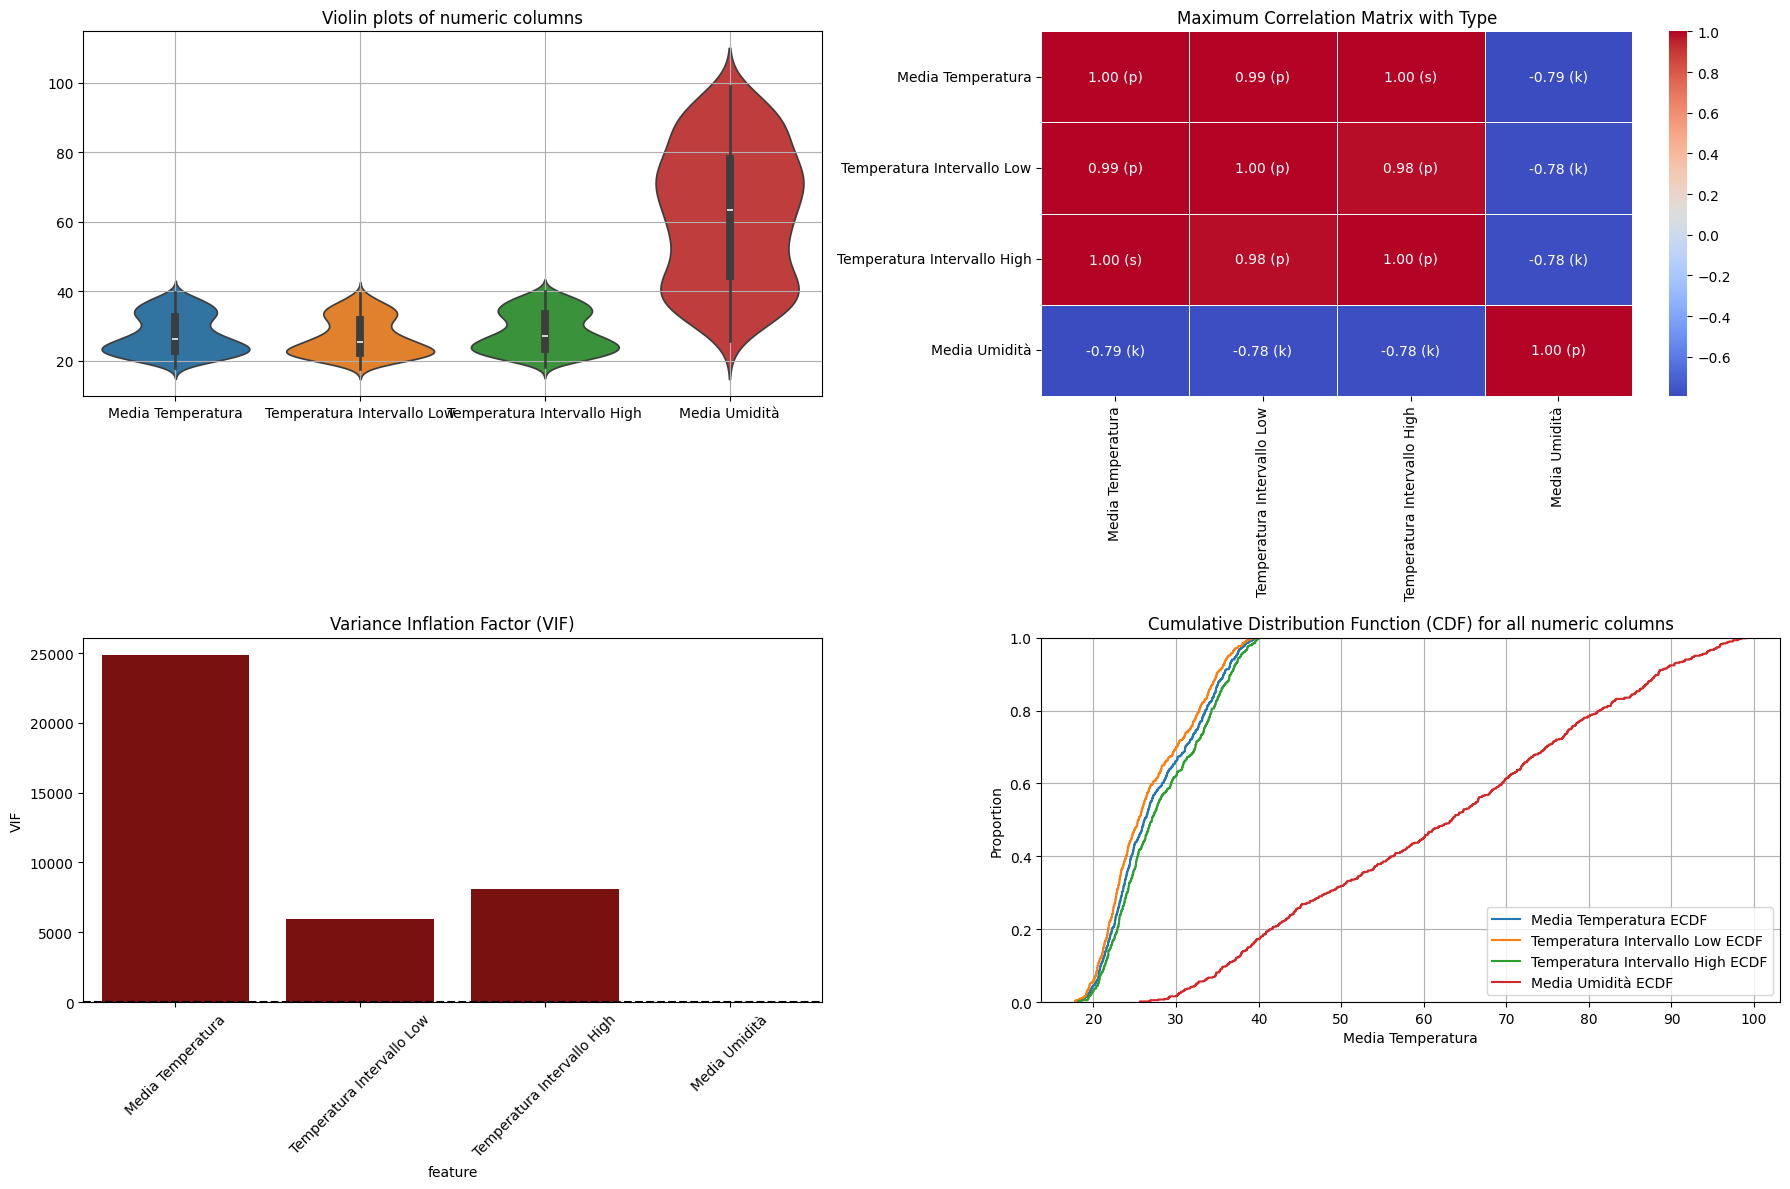

In [ ]:
#@title Exploratory Data Analysis : Visual-Quantitative Analysis

create_grid_visualizations(df_meteo_completo)



                           Data       Ora
DateTime                                 
2024-07-30 12:00:00  2024-07-30  12:00:00
2024-07-30 13:00:00  2024-07-30  13:00:00
2024-07-30 14:00:00  2024-07-30  14:00:00
2024-07-30 15:00:00  2024-07-30  15:00:00
2024-07-30 16:00:00  2024-07-30  16:00:00


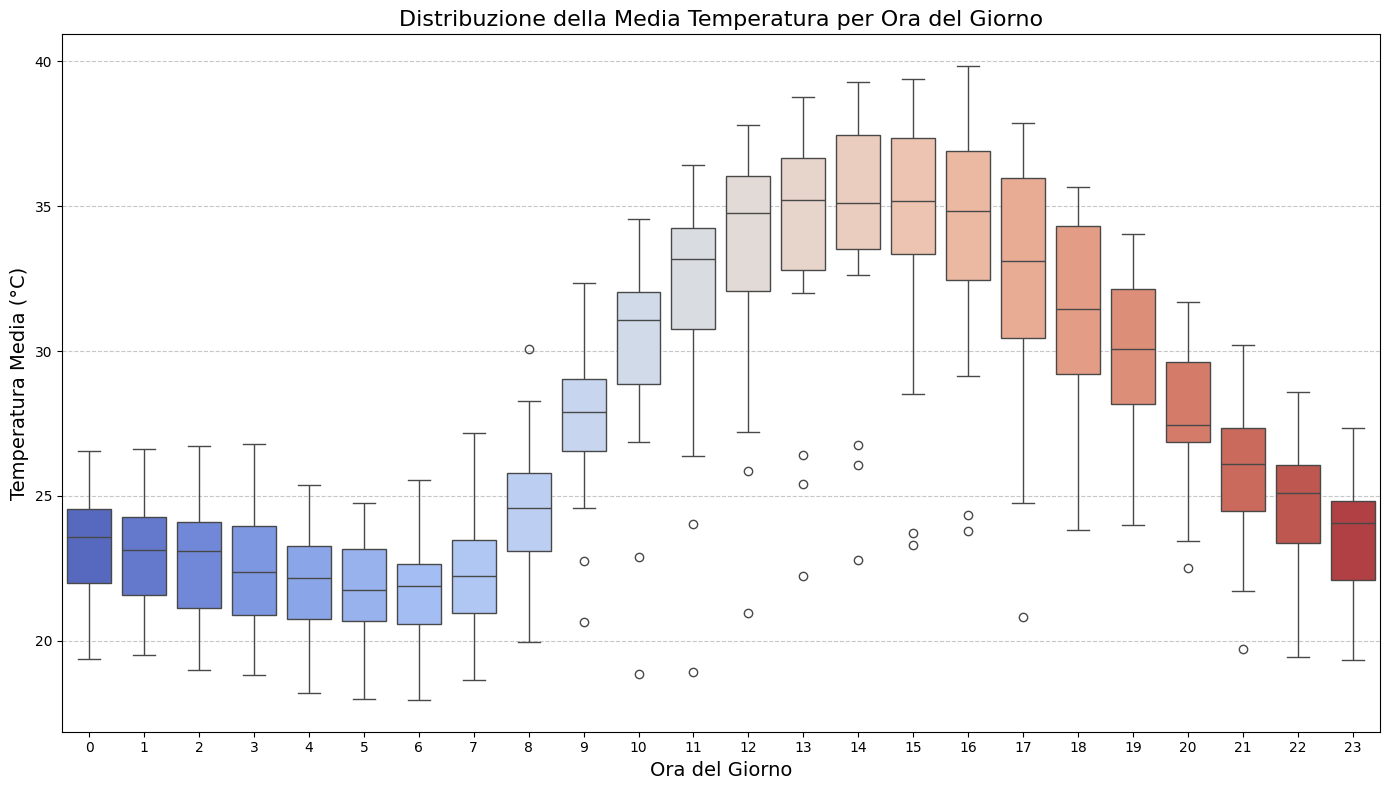

In [ ]:
#@title Visualizzazione Temperatura Arco della giornata
# Assicurati che l'indice sia di tipo datetime
df_meteo_completo_2 = df_meteo_completo.copy()
df_meteo_completo_2.index = pd.to_datetime(df_meteo_completo_2.index)

# Splitta l'indice datetime in due nuove colonne
df_meteo_completo_2['Data'] = df_meteo_completo_2.index.date  # Solo la data
df_meteo_completo_2['Ora'] = df_meteo_completo_2.index.time  # Solo l'ora

# Visualizza il risultato
print(df_meteo_completo_2[['Data', 'Ora']].head())  # Mostra le prime righe delle nuove colonne

# Assicurati che l'indice sia datetime
df_meteo_completo_2.index = pd.to_datetime(df_meteo_completo_2.index)

# Crea una colonna con l'ora (senza minuti e secondi)
df_meteo_completo_2['Ora'] = df_meteo_completo_2.index.hour

# Box plot della Media Temperatura per ogni ora
plt.figure(figsize=(14, 8))
sns.boxplot(x='Ora', y='Media Temperatura', data=df_meteo_completo_2, palette="coolwarm")
plt.title('Distribuzione della Media Temperatura per Ora del Giorno', fontsize=16)
plt.xlabel('Ora del Giorno', fontsize=14)
plt.ylabel('Temperatura Media (°C)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


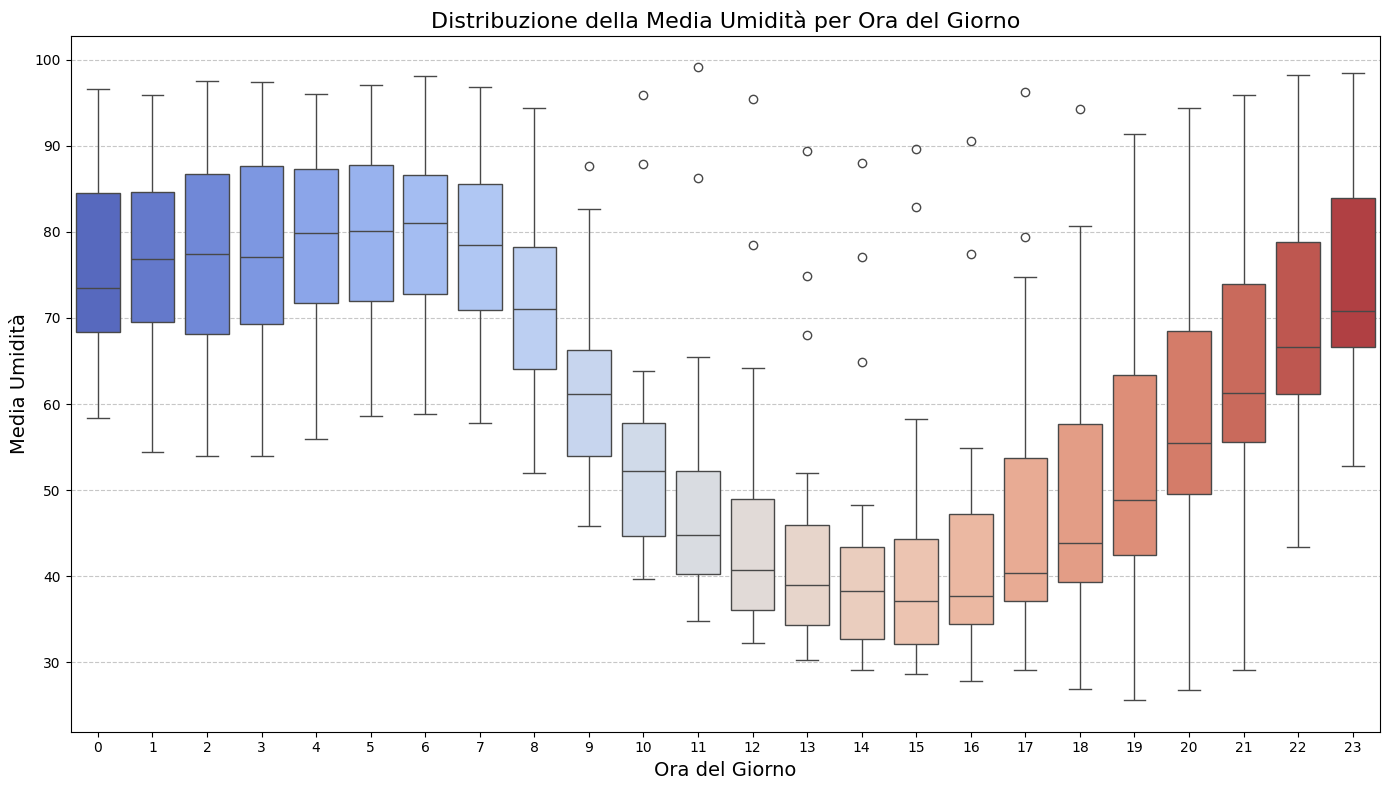

In [ ]:
#@title Visualizzazione Umidità nell'arco della giornata
# Assicurati che l'indice sia di tipo datetime
df_meteo_completo_2 = df_meteo_completo.copy()
df_meteo_completo_2.index = pd.to_datetime(df_meteo_completo_2.index)

# Splitta l'indice datetime in due nuove colonne
df_meteo_completo_2['Data'] = df_meteo_completo_2.index.date  # Solo la data
df_meteo_completo_2['Ora'] = df_meteo_completo_2.index.time  # Solo l'ora

# Assicurati che l'indice sia datetime
df_meteo_completo_2.index = pd.to_datetime(df_meteo_completo_2.index)

# Crea una colonna con l'ora (senza minuti e secondi)
df_meteo_completo_2['Ora'] = df_meteo_completo_2.index.hour

# Box plot della Media Temperatura per ogni ora
plt.figure(figsize=(14, 8))
sns.boxplot(x='Ora', y='Media Umidità', data=df_meteo_completo_2, palette="coolwarm")
plt.title('Distribuzione della Media Umidità per Ora del Giorno', fontsize=16)
plt.xlabel('Ora del Giorno', fontsize=14)
plt.ylabel('Media Umidità', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
#@title Eliminazione orario dall'indice
# Eliminiamo l'orario dall'indice per andare ad accorpare tutti i dati dello stesso giorno

# Controllo sull'indice che sia effettivamente un datetime
df_meteo_completo.index = pd.to_datetime(df_meteo_completo.index, format="%Y-%m-%d %H:%M:%S")
df_3.index = pd.to_datetime(df_3.index, format="%Y-%m-%d %H:%M:%S")

# Mantieni solo la parte della data
df_meteo_completo.index = df_meteo_completo.index.date
df_3.index = df_3.index.date
print(df_meteo_completo.head())

            Media Temperatura  Temperatura Intervallo Low  \
2024-07-30              34.98                        34.8   
2024-07-30              35.08                        34.8   
2024-07-30              35.14                        34.8   
2024-07-30              34.40                        33.9   
2024-07-30              33.11                        32.6   

            Temperatura Intervallo High  Media Umidità  
2024-07-30                         35.1          35.38  
2024-07-30                         35.3          33.89  
2024-07-30                         35.5          33.49  
2024-07-30                         34.8          35.22  
2024-07-30                         34.0          35.30  


In [ ]:
#@title Accorpamento dati stesso giorno


df_meteo_completo.index = pd.to_datetime(df_meteo_completo.index, format="%Y-%m-%d %H:%M:%S")
# Funzioni di aggregazione per le colonne specifiche
agg_functions = {
    'Media Temperatura': ['mean', 'var'],  # Media, varianza
    'Media Umidità': ['mean', 'var'],      # Media, varianza
    'Temperatura Intervallo High': 'max',  # Valore massimo
    'Temperatura Intervallo Low': 'min'    # Valore minimo
}

# Raggruppa per indice (data) e calcola le statistiche
df_aggregato = df_meteo_completo.groupby(df_meteo_completo.index).agg(agg_functions)
df_3_aggregato = df_3.groupby(df_3.index).agg(agg_functions)

# Aggrego le colonne
df_aggregato.columns = [' '.join(col).strip() for col in df_aggregato.columns.values]
df_aggregato = df_aggregato.round(2)

df_3_aggregato.columns = [' '.join(col).strip() for col in df_3_aggregato.columns.values]
df_3_aggregato = df_3_aggregato.round(2)

# Stampa di verifica per il risultato
print(df_aggregato.head())


            Media Temperatura mean  Media Temperatura var  Media Umidità mean  \
2024-07-30                   30.63                  19.83               40.54   
2024-07-31                   28.93                  41.97               51.92   
2024-08-01                   31.07                  32.62               43.79   
2024-08-02                   27.95                  26.44               65.82   
2024-08-03                   25.81                   7.70               72.29   

            Media Umidità var  Temperatura Intervallo High max  \
2024-07-30              74.85                            35.50   
2024-07-31             239.60                            38.65   
2024-08-01             160.94                            39.75   
2024-08-02             294.46                            36.95   
2024-08-03             156.59                            31.15   

            Temperatura Intervallo Low min  
2024-07-30                           22.25  
2024-07-31                

In [ ]:
#@title Rinomina colonne
#Rinonima delle colonne solo per una maggior chiarezza
df_aggregato.rename(columns={'Media Temperatura mean': 'Media Temperatura'}, inplace=True)
df_aggregato.rename(columns={'Media Temperatura var': 'Varianza Temperatura'}, inplace=True)
df_aggregato.rename(columns={'Media Umidità mean': 'Media Umidità'}, inplace=True)
df_aggregato.rename(columns={'Media Umidità var': 'Varianza Umidità'}, inplace=True)
#df_aggregato.rename(columns={'Media Umidità max': 'Umidità Massima'}, inplace = True)
#df_aggregato.rename(columns={'Media Umidità min': 'Umidità Minima'}, inplace = True)
df_aggregato.rename(columns={'Temperatura Intervallo High max': 'Temperatura Massima'}, inplace=True)
df_aggregato.rename(columns={'Temperatura Intervallo Low min': 'Temperatura Minima'}, inplace=True)

df_3_aggregato.rename(columns={'Media Temperatura mean': 'Media Temperatura'}, inplace=True)
df_3_aggregato.rename(columns={'Media Temperatura var': 'Varianza Temperatura'}, inplace=True)
df_3_aggregato.rename(columns={'Media Umidità mean': 'Media Umidità'}, inplace=True)
df_3_aggregato.rename(columns={'Media Umidità var': 'Varianza Umidità'}, inplace=True)
#df_3_aggregato.rename(columns={'Media Umidità max': 'Umidità Massima'}, inplace = True)
#df_3_aggregato.rename(columns={'Media Umidità min': 'Umidità Minima'}, inplace = True)
df_3_aggregato.rename(columns={'Temperatura Intervallo High max': 'Temperatura Massima'}, inplace=True)
df_3_aggregato.rename(columns={'Temperatura Intervallo Low min': 'Temperatura Minima'}, inplace=True)


In [ ]:
#@title Gestione ultima riga
# Le ultime istanze avendo una sola fascia oraria non hanno varianza, per questo
# si è deciso di eliminare la riga

#df_aggregato.fillna(method='ffill', inplace=True)
#df_3_aggregato.fillna(method='ffill', inplace=True)
df_aggregato = df_aggregato[:-1]
df_3_aggregato = df_3_aggregato[:-1]


#Analisi preliminare Dati Cattura

I file rappresentano un registro delle catture di insetti in un intervallo temporale.

In [ ]:
print("Dati Cattura 1: ")
print(df_ca_1.describe())
print("---------------------------------------------\n")
print("Dati Cattura 2: ")
print(df_ca_1.describe())
print("---------------------------------------------\n")
print("Dati Cattura 3: ")
print(df_ca_1.describe())
print("---------------------------------------------\n")

Dati Cattura 1: 
       Numero di insetti  Nuove catture (per evento)
count          24.000000                   24.000000
mean            0.708333                    0.333333
std             1.488482                    0.916831
min             0.000000                    0.000000
25%             0.000000                    0.000000
50%             0.000000                    0.000000
75%             0.250000                    0.000000
max             5.000000                    4.000000
---------------------------------------------

Dati Cattura 2: 
       Numero di insetti  Nuove catture (per evento)
count          24.000000                   24.000000
mean            0.708333                    0.333333
std             1.488482                    0.916831
min             0.000000                    0.000000
25%             0.000000                    0.000000
50%             0.000000                    0.000000
75%             0.250000                    0.000000
max             5.

In [ ]:
#@title Eliminazione orario dall'indice

# Assicuriamoci che l'indice sia in formato datetime
df_ca_1.index = pd.to_datetime(df_ca_1.index, format="%Y-%m-%d %H:%M:%S")
# Mantieni solo la parte della data
df_ca_1.index = df_ca_1.index.date

df_ca_2.index = pd.to_datetime(df_ca_2.index, format="%Y-%m-%d %H:%M:%S")
# Mantieni solo la parte della data
df_ca_2.index = df_ca_2.index.date

df_ca_3.index = pd.to_datetime(df_ca_3.index, format="%Y-%m-%d %H:%M:%S")
# Mantieni solo la parte della data
df_ca_3.index = df_ca_3.index.date

df_ca_1 = df_ca_1.fillna(0)
df_ca_2 = df_ca_2.fillna(0)
df_ca_3 = df_ca_3.fillna(0)

In [ ]:
#@title Conversione colonne evento in binario
#In caso di evento pari a Cleaning il valore sarà 1 altrimenti 0
df_ca_1['Evento'] = (df_ca_1['Evento'] == 'Cleaning').astype(int)
df_ca_2['Evento'] = (df_ca_2['Evento'] == 'Cleaning').astype(int)
df_ca_3['Evento'] = (df_ca_3['Evento'] == 'Cleaning').astype(int)

In [ ]:
#@title Eliminazione colonna recensito
#La colonna Recensito è priva di informazione avendo tutti 'si'
del df_ca_1['Recensito']
del df_ca_2['Recensito']
del df_ca_3['Recensito']

In [ ]:
#@title Somma Righe con ugual indice
#Vado a sommare le righe con uguale indice all'interno dello stesso dataset
#In questo modo la riga di Evento si unisce alle altre e "guadagno" una nuova feature
#che può essere utile per il conteggio del numero di insetti
df_ca_1 = df_ca_1.groupby(df_ca_1.index).sum()
df_ca_2 = df_ca_2.groupby(df_ca_2.index).sum()
df_ca_3 = df_ca_3.groupby(df_ca_3.index).sum()

In [ ]:
#@title Unione grafico catture 1 e 2

# Unione dataset delle catture 1 e 2 con modalità inner in modo da prendere solo i valori in comune
merged_df = pd.merge(df_ca_1, df_ca_2, left_index=True, right_index=True, how='inner', suffixes=('_1', '_2'))

# Poniamo pari a uno i dati in cui sono Nan non avendone a disposizione nei giorni non comuni
merged_df['Numero di insetti_1'].fillna(0, inplace=True)
merged_df['Numero di insetti_2'].fillna(0, inplace=True)
merged_df['Nuove catture (per evento)_1'].fillna(0, inplace=True)
merged_df['Nuove catture (per evento)_2'].fillna(0, inplace=True)

# Sommiamo le colonne Numero di insetti e Nuove catture
merged_df['Numero di insetti'] = merged_df['Numero di insetti_1'] + merged_df['Numero di insetti_2']
merged_df['Nuove catture (per evento)'] = merged_df['Nuove catture (per evento)_1'] + merged_df['Nuove catture (per evento)_2']

# Eliminiamo le colonne non necessarie
df_catture_imola = merged_df.drop(['Numero di insetti_1', 'Numero di insetti_2',
                           'Nuove catture (per evento)_1', 'Nuove catture (per evento)_2'], axis=1)



In [ ]:
#@title Estrazione variabile target

# la variabile target è cambiata da INTERA a BINARIA

#Estraiamo la variabile target "Nuove Catture (per evento)"
Target_insetti_catturati = df_catture_imola.copy()
Target_insetti_catturati = Target_insetti_catturati.drop(['Numero di insetti','Evento_1','Evento_2'], axis=1)

# la variabile target è cambiata da INTERA a BINARIA
Target_insetti_catturati['Nuove catture (per evento)'] = (Target_insetti_catturati['Nuove catture (per evento)'] >= 1).astype(int)

Target_test = df_ca_3.copy()
Target_test = Target_test.drop(['Numero di insetti','Evento'], axis=1)
Target_test['Nuove catture (per evento)'] = (Target_test['Nuove catture (per evento)'] >= 1).astype(int)

#Estriamo la variabile target "Numero di insetti"
Target_numero_insetti = df_catture_imola.copy()
Target_numero_insetti = Target_numero_insetti.drop(['Nuove catture (per evento)'], axis=1)
Target_numero_insetti_test = df_ca_3.copy()
Target_numero_insetti_test = Target_numero_insetti_test.drop(['Nuove catture (per evento)'], axis=1)

# Costruzione dataset finale

In [ ]:
#@title Unione Variabile Target con Dati Meteo
df_finale = df_aggregato.join(Target_insetti_catturati, how = 'inner')
df_finale_regressione = df_aggregato.join(Target_numero_insetti, how = 'inner')

df_test = df_3_aggregato.join(Target_test,how = 'inner')
df_test_regressione = df_3_aggregato.join(Target_numero_insetti_test,how = 'inner')

In [ ]:
#@title Conteggio valori nulli
print(df_finale_regressione.isnull().sum())

Media Temperatura       0
Varianza Temperatura    0
Media Umidità           0
Varianza Umidità        0
Temperatura Massima     0
Temperatura Minima      0
Evento_1                0
Evento_2                0
Numero di insetti       0
dtype: int64


In [ ]:
#@title Salvataggio Dataset
df_finale.to_csv('df_finale_classificazione_imola.csv')
df_finale_regressione.to_csv('df_finale_regressione_imola.csv')
df_test.to_csv('df_classificazione_test_imola.csv')
df_test_regressione.to_csv('df_test_regressione_imola.csv')

# Problema di classificazione


1.   Visualizzazione di tutte le features
2.   Gestione delle Features
3.   Visualizzazione delle nuove features
4.   Visualizzazione serie temporali


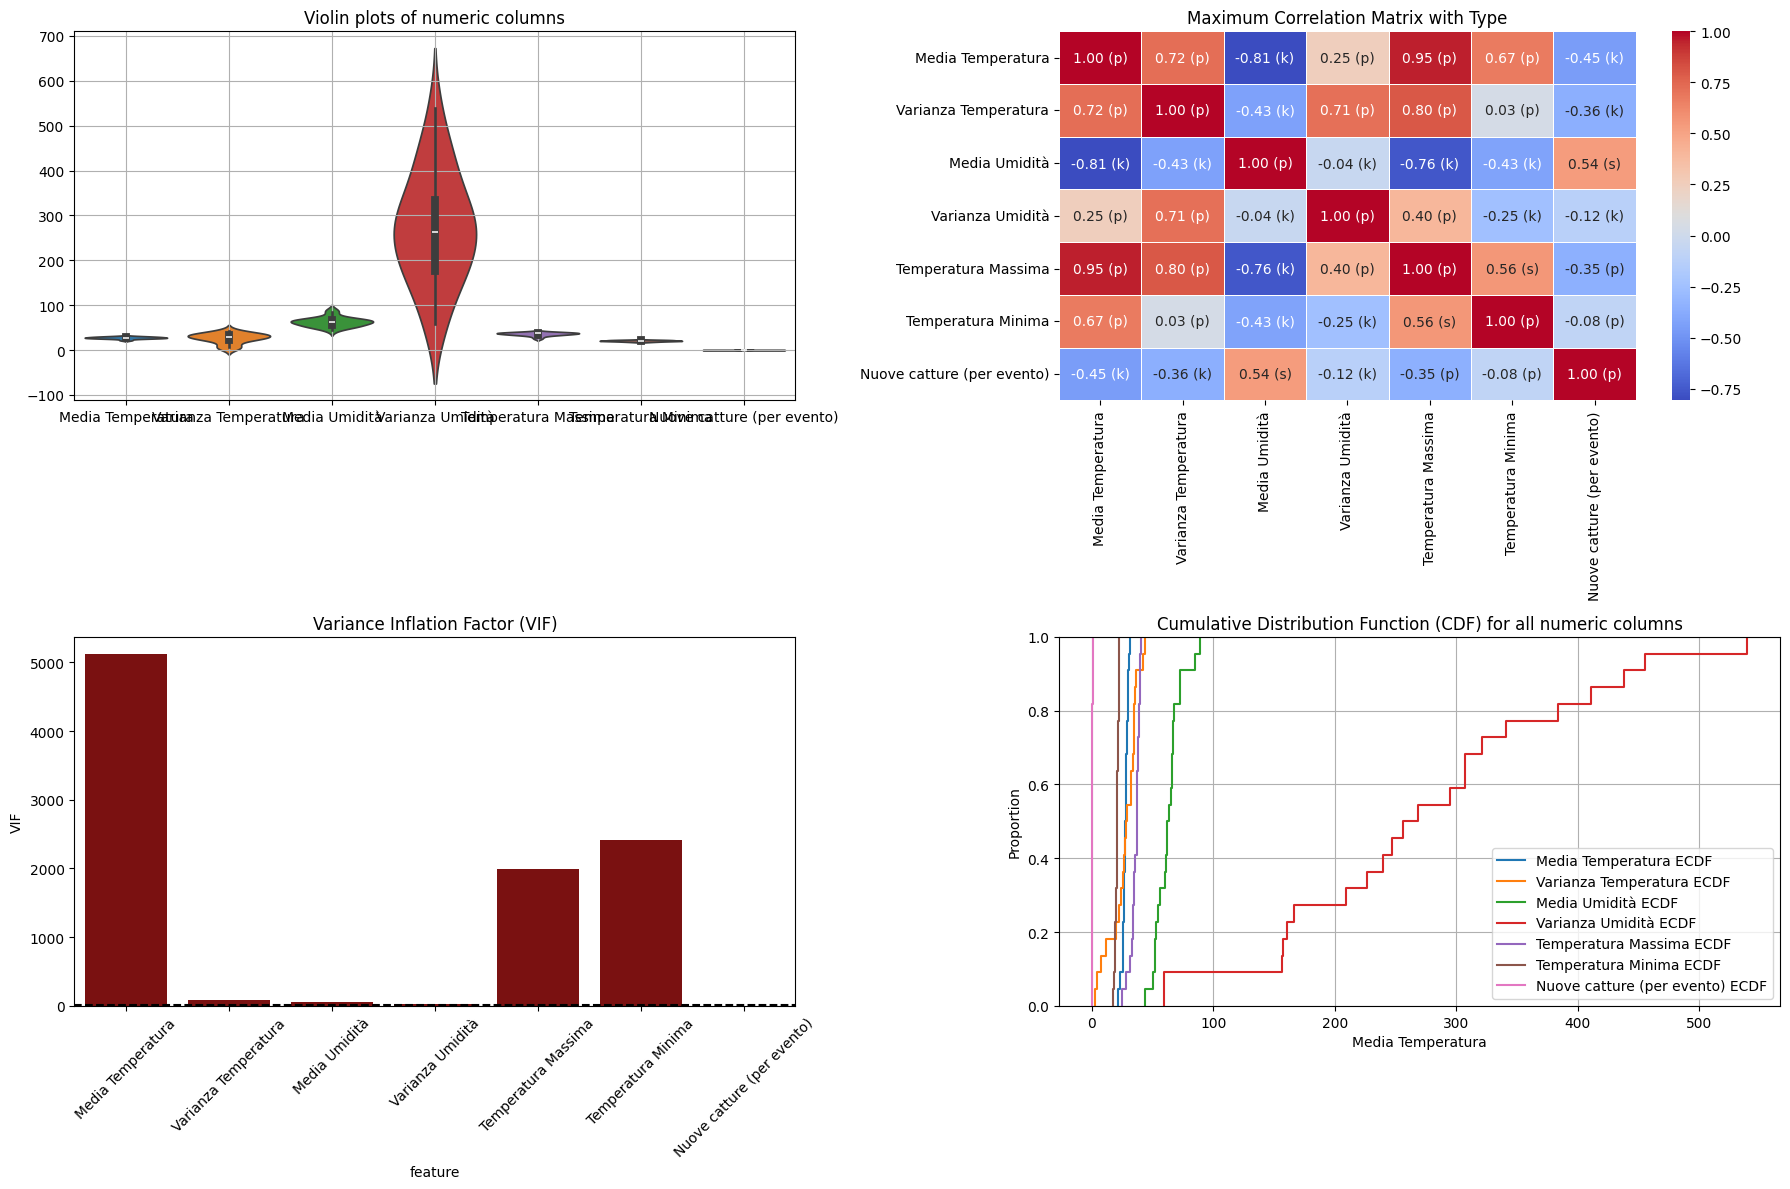

In [ ]:
#@title Analisi Esplorativa dei Dati: Analisi Visivo-Quantitativa
create_grid_visualizations(df_finale)

Sulla base delle analisi effettuate, si è deciso di eliminare Temperatura Minima, avendo poca correlazione con la variabile target.
Si è effettuata due volte la PCA:
- temperatura_pca : Media Temperatura + Temperatura massima
- Varianza_pca : Varianza Umidità + Varianza Temperatura

In ultimo si è deciso di tenere Media Umidità.

In [ ]:
# Eliminazione feature poco correlate
df_finale_2 = df_finale.copy()
df_test_2 = df_test.copy()

del df_finale_2['Temperatura Minima']
del df_test_2['Temperatura Minima']

# Scaling (addestramento sul training set)
scaler = StandardScaler()
features_scaled_temperatura_train = scaler.fit_transform(df_finale_2[['Media Temperatura', 'Temperatura Massima']])
features_scaled_temperatura_test = scaler.transform(df_test_2[['Media Temperatura', 'Temperatura Massima']])

# PCA per la temperatura
pca = PCA(n_components=1)
df_finale_2['Temperatura_pca'] = pca.fit_transform(features_scaled_temperatura_train)
df_test_2['Temperatura_pca'] = pca.transform(features_scaled_temperatura_test)

df_finale_2 = df_finale_2.drop(['Media Temperatura', 'Temperatura Massima'], axis=1)
df_test_2 = df_test_2.drop(['Media Temperatura', 'Temperatura Massima'], axis=1)

# Scaling per la varianza
features_scaled_varianza_train = scaler.fit_transform(df_finale_2[['Varianza Temperatura', 'Varianza Umidità']])
features_scaled_varianza_test = scaler.transform(df_test_2[['Varianza Temperatura', 'Varianza Umidità']])

# PCA per la varianza
pca_varianza = PCA(n_components=1)
df_finale_2['Varianza_pca'] = pca_varianza.fit_transform(features_scaled_varianza_train)
df_test_2['Varianza_pca'] = pca_varianza.transform(features_scaled_varianza_test)

df_finale_2 = df_finale_2.drop(['Varianza Temperatura', 'Varianza Umidità'], axis=1)
df_test_2 = df_test_2.drop(['Varianza Temperatura', 'Varianza Umidità'], axis=1)


In [ ]:
#@title modifica indice df_finale_2
df_finale_2.index = pd.to_datetime(df_finale_2.index, format="%Y-%m-%d %H:%M:%S")
df_test_2.index = pd.to_datetime(df_test_2.index, format="%Y-%m-%d %H:%M:%S")

df_finale_2.index = df_finale_2.index.strftime('%Y-%m-%d %H:%M:%S')
df_test_2.index = df_test_2.index.strftime('%Y-%m-%d %H:%M:%S')

df_finale_2.index = pd.to_datetime(df_finale_2.index)
df_test_2.index = pd.to_datetime(df_test_2.index)
#sort by datetime
#df_finale_2.index = df_finale_2.sort_index()
#df_test_2.index = df_test_2.sort_index()
#conta valori nulli per colonna
print(df_finale_2.isnull().sum())
print(df_test_2.isnull().sum())

Media Umidità                 0
Nuove catture (per evento)    0
Temperatura_pca               0
Varianza_pca                  0
dtype: int64
Media Umidità                 0
Nuove catture (per evento)    0
Temperatura_pca               0
Varianza_pca                  0
dtype: int64


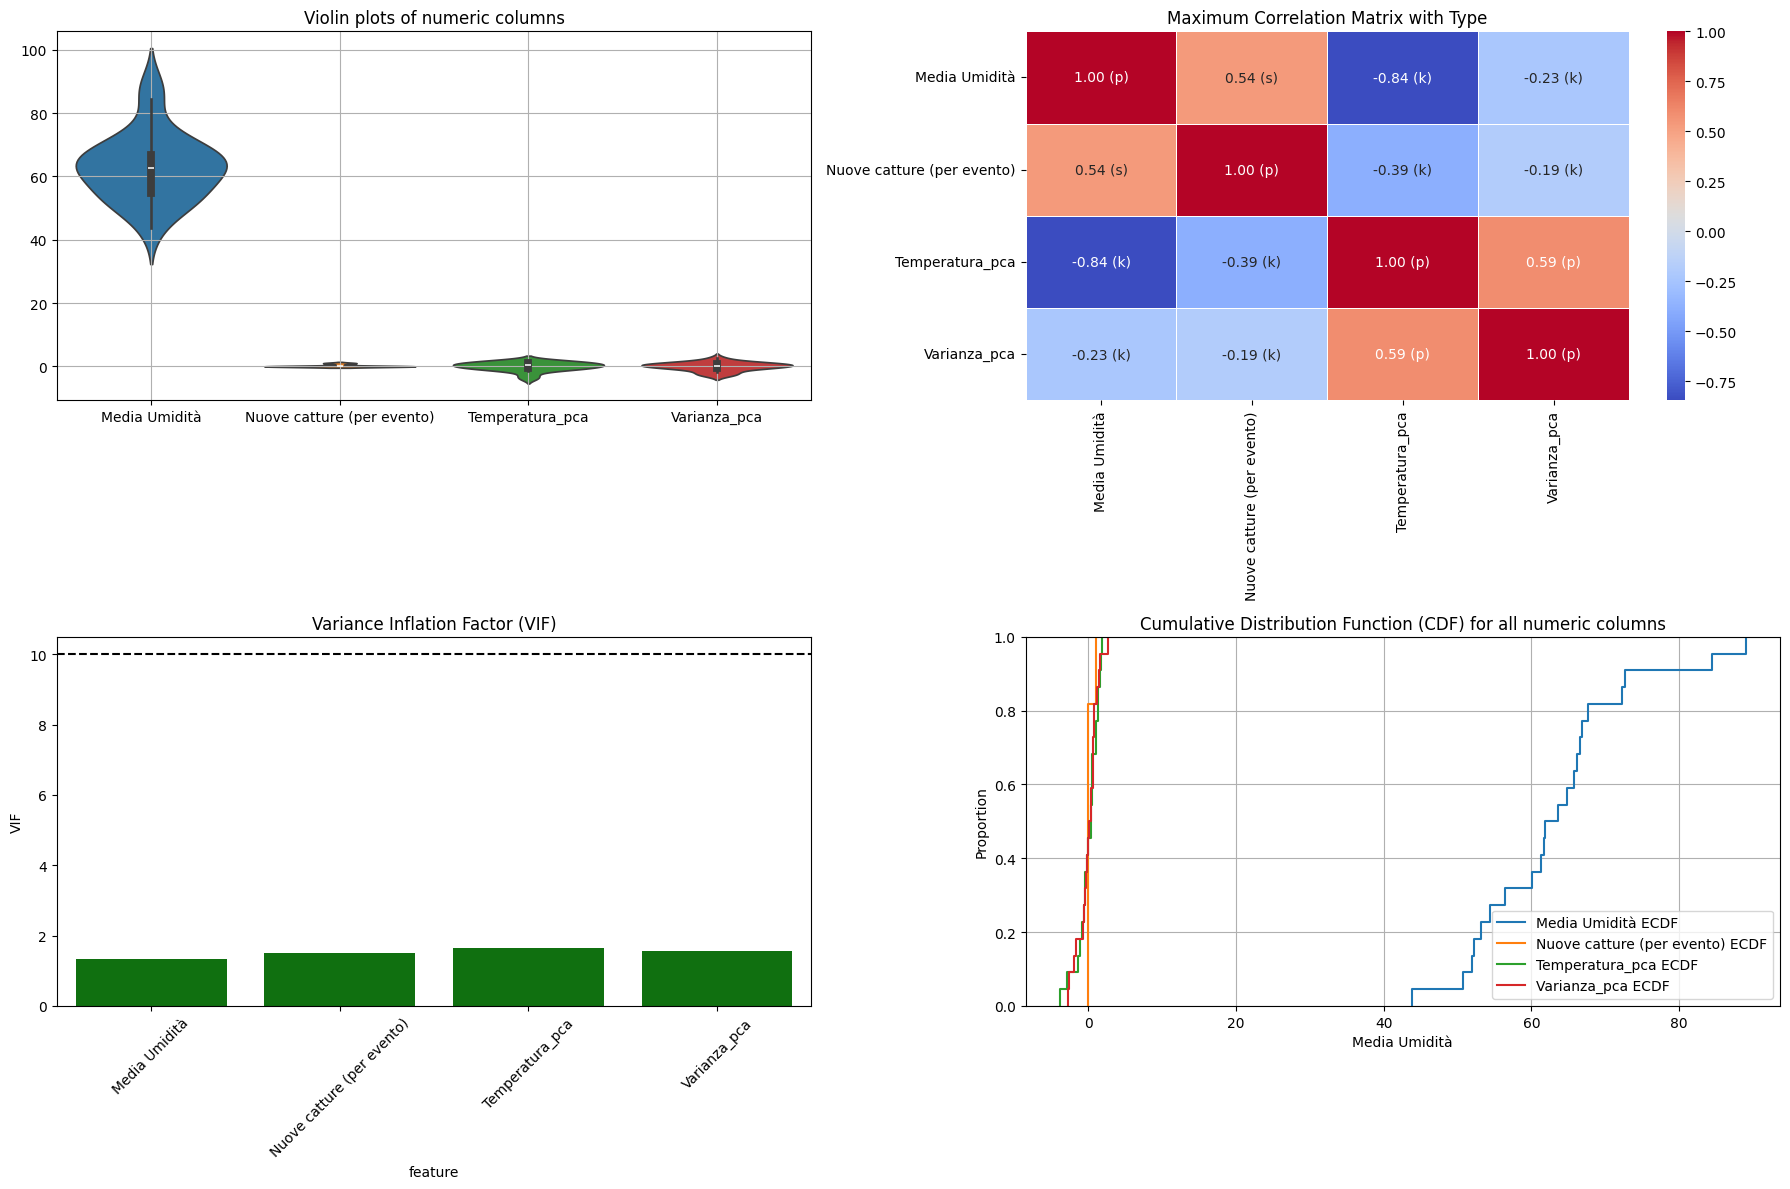

In [ ]:
#@title Visualizzazione dopo la gestione delle Features
create_grid_visualizations(df=df_finale_2)

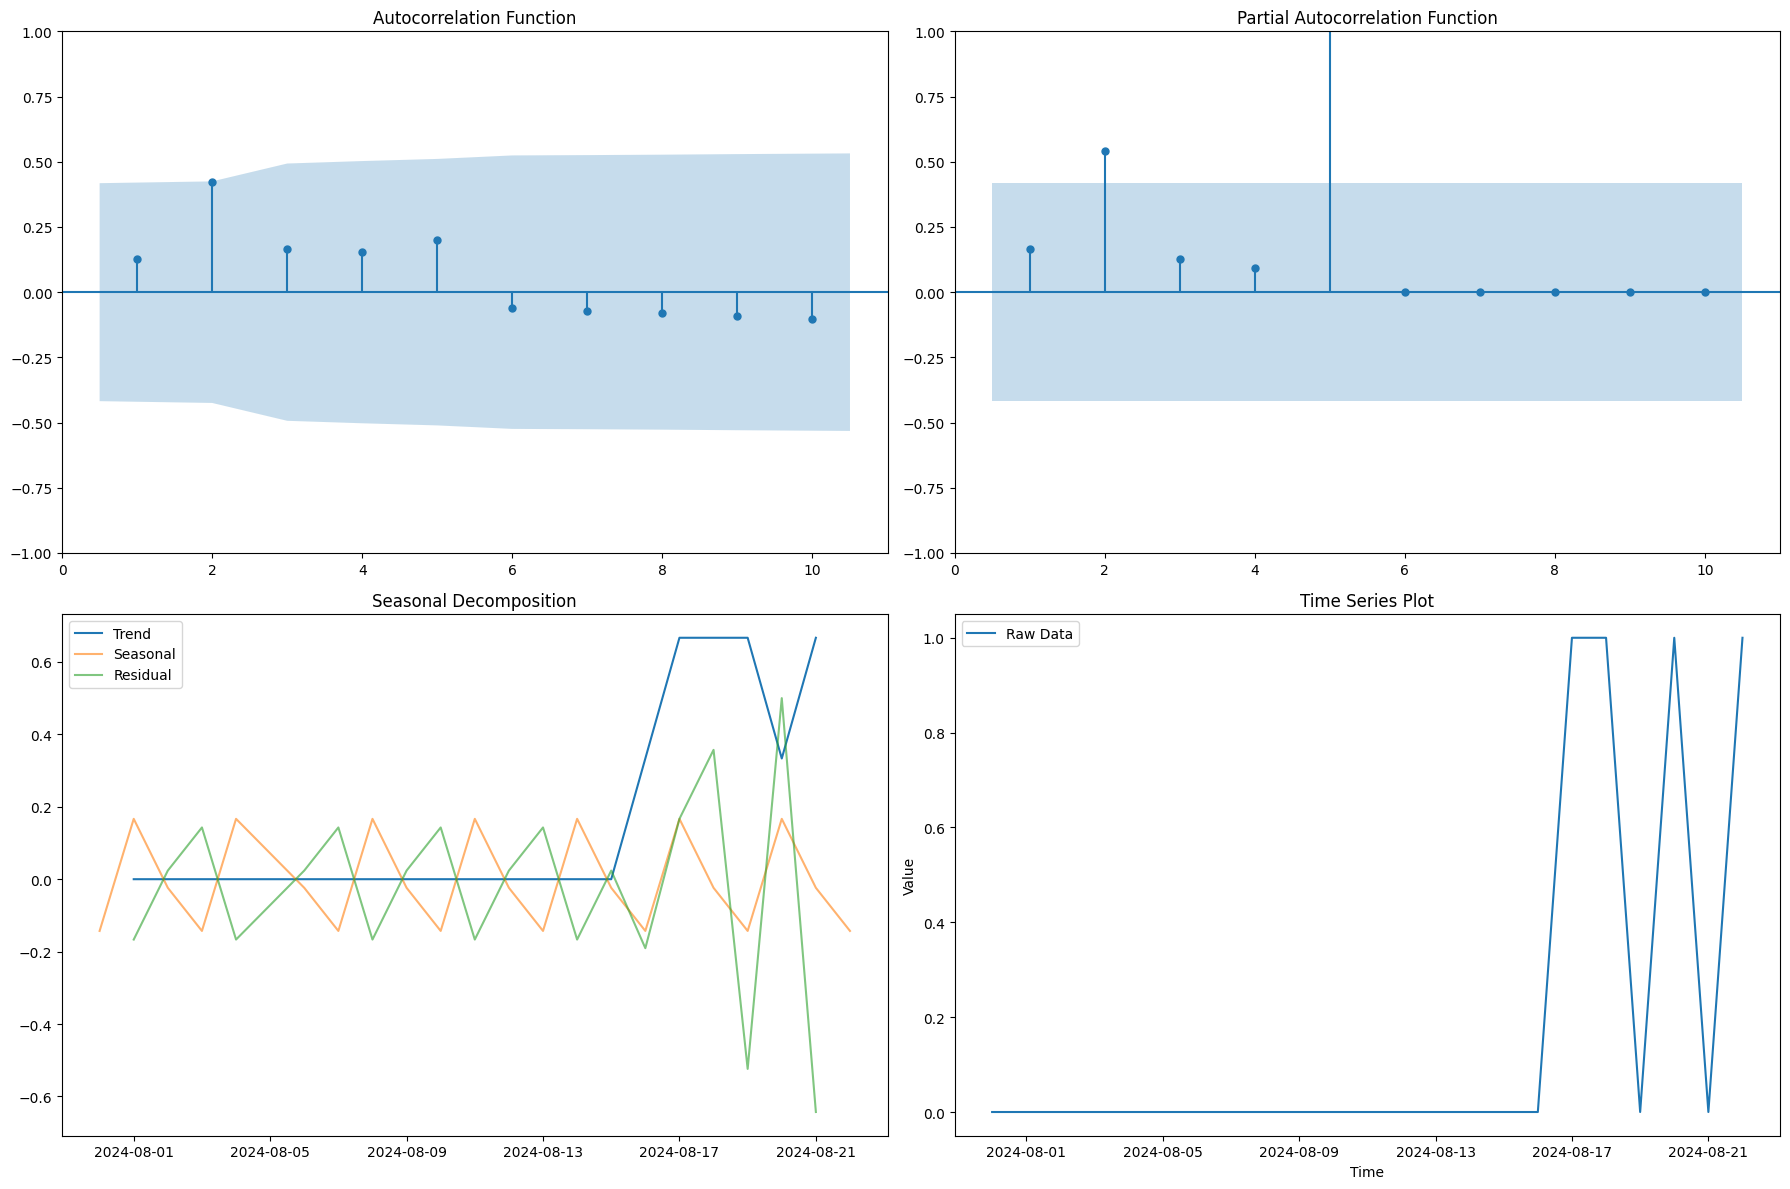

In [ ]:
#@title Analisi Esplorativa dei Dati: Serie Temporali

advanced_time_series_analysis(df_finale_2, 'Nuove catture (per evento)', lags=10, period=3)


## Addestramento

Per l'addestramento si è deciso di utilizzare e confrontare:
- un **modello statistico** (ARIMAX);
- una **tecnica di Machine Learning** (Ensamble Learning);
- una **tecnica di Deep Learning** (MLP+Cross Validation).

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/di

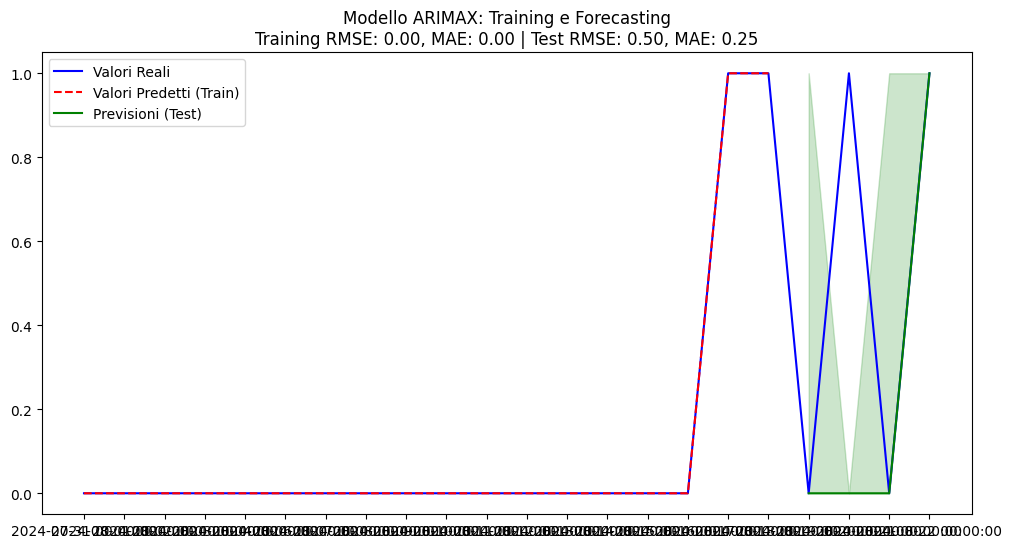

In [ ]:
#@title ARIMAX - Classificazione
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Assumi che 'df_finale' sia il tuo DataFrame iniziale
data_clean = df_finale_2.copy()
data_clean.index = pd.to_datetime(data_clean.index, format="%Y-%m-%d %H:%M:%S")
data_clean.index = data_clean.index.strftime('%Y-%m-%d %H:%M:%S')
y = data_clean['Nuove catture (per evento)']  # Target
X = data_clean.drop(['Nuove catture (per evento)'], axis=1)  # Variabili esogene

# Suddivisione cronologica del dataset in Training e Test
train_size = int(len(data_clean) * 0.85)  # 85% per il Training, 15% per il Test
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]

# Definizione e allenamento del modello ARIMAX sul Training Set
arimax_model = sm.tsa.ARIMA(endog=y_train, exog=X_train, order=(10, 0, 11)).fit()

# Predizioni sul Training Set
fitted_values_train = arimax_model.fittedvalues.clip(lower=0).round()

# Previsioni sul Test Set
arimax_forecast = arimax_model.get_forecast(steps=len(y_test), exog=X_test)
forecasted_values_test = arimax_forecast.predicted_mean.clip(lower=0).round()

# Intervalli di confidenza per il Test Set
confidence_intervals_test = arimax_forecast.conf_int()
confidence_intervals_test[confidence_intervals_test < 0] = 0  # Evita valori negativi
confidence_intervals_test = confidence_intervals_test.round()

# Calcolo dei residui
residuals_train_arimax = y_train - fitted_values_train
residuals_test_arimax = y_test - forecasted_values_test

# Calcolo delle metriche
# Metriche sul Training Set
rmse_train = np.sqrt(mean_squared_error(y_train, fitted_values_train))
mae_train = mean_absolute_error(y_train, fitted_values_train)

# Metriche sul Test Set
rmse_test = np.sqrt(mean_squared_error(y_test, forecasted_values_test))
mae_test = mean_absolute_error(y_test, forecasted_values_test)

# Plot dei risultati
fig, ax = plt.subplots(figsize=(12, 6))

# Plot dei valori reali, predetti e previsti
ax.plot(y.index, y, label='Valori Reali', color='blue')
ax.plot(fitted_values_train.index, fitted_values_train, color='red', linestyle='--', label='Valori Predetti (Train)')
ax.plot(forecasted_values_test.index, forecasted_values_test, label='Previsioni (Test)', color='green')

# Aggiunta degli intervalli di confidenza
ax.fill_between(confidence_intervals_test.index,
                confidence_intervals_test.iloc[:, 0],
                confidence_intervals_test.iloc[:, 1],
                color='green', alpha=0.2)

# Titolo e legenda
ax.set_title(f'Modello ARIMAX: Training e Forecasting\n'
             f'Training RMSE: {rmse_train:.2f}, MAE: {mae_train:.2f} | '
             f'Test RMSE: {rmse_test:.2f}, MAE: {mae_test:.2f}')
ax.legend()

plt.show()


Gradient Boosting Machine - Training Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00         4

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

Gradient Boosting Machine - Test Classification Report:
               precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.50      0.67         2

    accuracy                           0.75         4
   macro avg       0.83      0.75      0.73         4
weighted avg       0.83      0.75      0.73         4

Random Forest - Training Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97        16
           1       1.00      0.75      0.86         4

    accuracy   

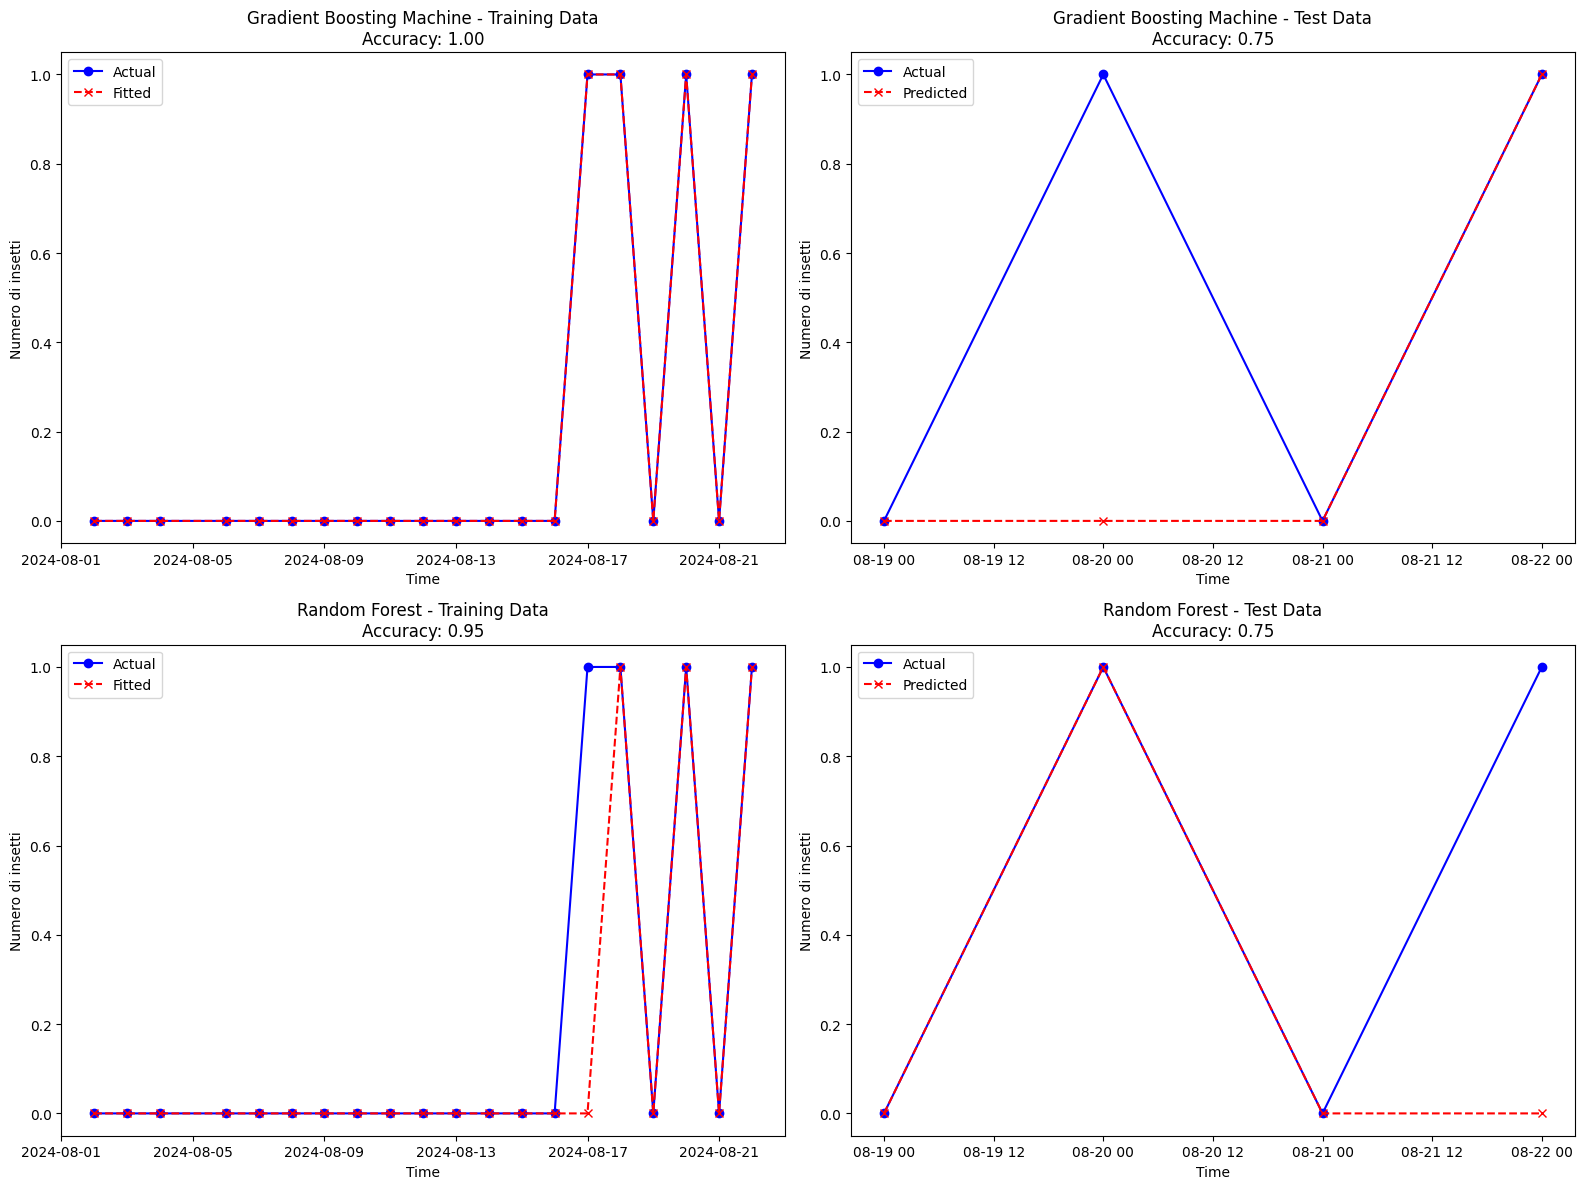

In [ ]:

def create_lagged_features(df, n_lags=3, target_col='Numero di insetti', exog_cols=[]):
    """ Crea caratteristiche lag per il target e usa le colonne esogene come sono. """
    for i in range(1, n_lags + 1):
        df[f'lag_{i}'] = df[target_col].shift(i)

    df.dropna(inplace=True)  # Rimuovi righe con valori NaN
    return df

def train_and_visualize(df, df_test, n_lags, exog_cols, target_col):
    """ Allena i modelli e visualizza i risultati, usando le colonne esogene senza lag. """
    df = create_lagged_features(df, n_lags=n_lags, exog_cols=exog_cols, target_col=target_col)
    df_test = create_lagged_features(df_test,n_lags=n_lags, exog_cols=exog_cols, target_col=target_col)
    # Usa solo le caratteristiche lag del target e le colonne esogene
    feature_cols = [f'lag_{i}' for i in range(1, n_lags + 1)] + exog_cols
    #X = df[feature_cols]
    #y = df[target_col]

    # Suddivisione cronologica dei dati
    #train_size = int(len(df) * 0.82)
    #X_train, y_train = X.iloc[:train_size], y.iloc[:train_size]
    #X_test, y_test = X.iloc[train_size:], y.iloc[train_size:]
    X_train = df[feature_cols]  # Feature del dataset di training
    y_train = df[target_col]    # Target del dataset di training

    X_test = df_test[feature_cols]  # Feature del dataset di test
    y_test = df_test[target_col]    # Target del dataset di test

    # Normalizzazione dei dati
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Inizializzazione dei modelli
    models = {
        "Gradient Boosting Machine": GradientBoostingClassifier(n_estimators=200, learning_rate=0.008, max_depth=2),
        "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=2)
    }

    # Creazione delle sottotrame per visualizzare i risultati
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))

    for i, (name, model) in enumerate(models.items()):
        # Allena il modello
        model.fit(X_train_scaled, y_train)
        y_pred_train = model.predict(X_train_scaled)
        y_pred_test = model.predict(X_test_scaled)

        # Calcola la precisione (accuracy)
        accuracy_train = accuracy_score(y_train, y_pred_train)
        accuracy_test = accuracy_score(y_test, y_pred_test)

        # Report di classificazione
        classification_rep_train = classification_report(y_train, y_pred_train)
        classification_rep_test = classification_report(y_test, y_pred_test)

        # Actual vs. Fitted sul Training Data
        axs[i][0].plot(y_train.index, y_train, label='Actual', marker='o', color='blue')
        axs[i][0].plot(y_train.index, y_pred_train, label='Fitted', linestyle='--', marker='x', color='red')
        axs[i][0].set_title(f'{name} - Training Data\nAccuracy: {accuracy_train:.2f}')
        axs[i][0].set_xlabel('Time')
        axs[i][0].set_ylabel('Numero di insetti')
        axs[i][0].legend()

        # Forecast vs. Actual sul Test Data
        axs[i][1].plot(y_test.index, y_test, label='Actual', marker='o', color='blue')
        axs[i][1].plot(y_test.index, y_pred_test, label='Predicted', linestyle='--', marker='x', color='red')
        axs[i][1].set_title(f'{name} - Test Data\nAccuracy: {accuracy_test:.2f}')
        axs[i][1].set_xlabel('Time')
        axs[i][1].set_ylabel('Numero di insetti')
        axs[i][1].legend()

        # Stampa il report di classificazione
        print(f"{name} - Training Classification Report:\n", classification_rep_train)
        print(f"{name} - Test Classification Report:\n", classification_rep_test)

    plt.tight_layout()
    plt.show()

    return models, df

df_copia = df_finale_2.copy()
df_test_copia = df_test_2.copy()

Columns = df_copia.columns.tolist()
if 'Nuove catture (per evento)' in Columns:
  Columns.remove('Nuove catture (per evento)')

Variabili_esogene = Columns
rf_models, real_data = train_and_visualize(df_copia, df_test_copia, n_lags=2, exog_cols=Variabili_esogene, target_col='Nuove catture (per evento)')

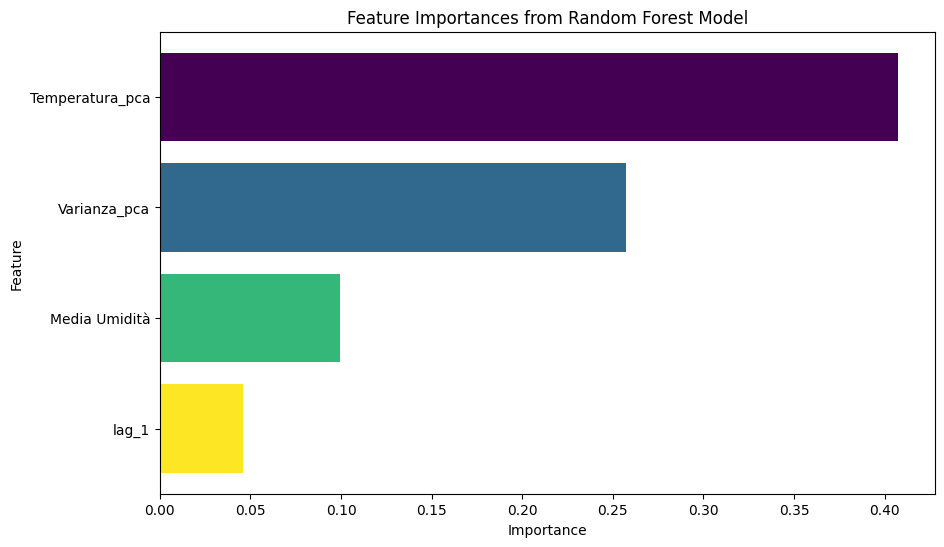

In [ ]:
# Seleziona il modello di Random Forest dal dizionario
rf_model = rf_models['Random Forest']

# Ora puoi accedere alle feature importances
importances = rf_model.feature_importances_

# Feature names (quelli che hai usato per addestrare il modello)
feature_names = [f'lag_{i}' for i in range(1, 2)] + Variabili_esogene  # Assicurati che queste corrispondano ai nomi reali

# Crea la lista di tuple (importanza, nome della feature) e ordina
feature_importances = sorted(zip(importances, feature_names), reverse=True, key=lambda x: x[0])

# Unzip into separate lists
sorted_importances, sorted_features = zip(*feature_importances)

# Plotting the Feature Importances
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_importances)))
plt.barh(sorted_features, sorted_importances, color=colors)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest Model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.show()


In [ ]:
#@title DeepLearning MLP
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

# Preprocessing and Creating Lagged Features
def create_lagged_features(df, n_lags=3, target_col='Nuove catture (per evento)', exog_cols=[]):
    lagged_df = df.copy()
    for i in range(1, n_lags + 1):
        lagged_df[f'lag_{i}'] = lagged_df[target_col].shift(i)
    lagged_df = lagged_df.dropna()  # Drop rows with NaN values
    return lagged_df

n_lags = 1  # Number of lags
df_copia = df_finale_2.copy()  # Assuming df_train is your training dataset
df_test_copia = df_test_2.copy()  # Assuming df_test is your test dataset
Columns = df_copia.columns.tolist()
if 'Nuove catture (per evento)' in Columns:
  Columns.remove('Nuove catture (per evento)')
exog_cols = Columns
# Create lagged features including exogenous variables
lagged_df = create_lagged_features(df_copia, n_lags=n_lags, target_col='Nuove catture (per evento)', exog_cols=exog_cols)
lagged_test = create_lagged_features(df_test_copia, n_lags=n_lags, target_col='Nuove catture (per evento)', exog_cols=exog_cols)

# Define features and target
feature_cols = [f'lag_{i}' for i in range(1, n_lags + 1)] + exog_cols
train_size = len(lagged_df)
X_train = lagged_df[feature_cols]
y_train = lagged_df['Nuove catture (per evento)']

X_test = lagged_test[feature_cols]
y_test = lagged_test['Nuove catture (per evento)']

# Binarizzazione del target
y_train_bin = (y_train >= 1).astype(int)  # Convert target to binary
y_test_bin = (y_test >= 1).astype(int)

# Scaling Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definizione del modello per classificazione binaria
inputs = tf.keras.Input(shape=(X_train_scaled.shape[1],))
x = tf.keras.layers.Dense(5, activation='relu')(inputs)
x = tf.keras.layers.Dense(20, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)  # Attivazione sigmoide per classificazione binaria
model_binary = tf.keras.Model(inputs=inputs, outputs=outputs)


# Compilazione del modello
model_binary.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Per classificazione binaria
    metrics=['accuracy']
)
pesi_loss = {0: 1, 1: 2}
# Addestramento del modello
history = model_binary.fit(
    X_train_scaled, y_train_bin,
    epochs=50,
    batch_size=16,
    validation_data=(X_test_scaled, y_test_bin),
    verbose=1,
    class_weight = pesi_loss
)

# Previsioni su training e test set
y_train_pred_probs = model_binary.predict(X_train_scaled)
y_test_pred_probs = model_binary.predict(X_test_scaled)

# Soglia per classificazione binaria
threshold = 0.5
y_train_pred = (y_train_pred_probs >= threshold).astype(int).flatten()
y_test_pred = (y_test_pred_probs >= threshold).astype(int).flatten()

# Accuratezza
accuracy_train = accuracy_score(y_train_bin, y_train_pred)
accuracy_test = accuracy_score(y_test_bin, y_test_pred)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 339ms/step - accuracy: 0.5159 - loss: 0.8876 - val_accuracy: 0.6000 - val_loss: 0.6898
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5367 - loss: 0.8893 - val_accuracy: 0.6000 - val_loss: 0.6897
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5159 - loss: 0.8597 - val_accuracy: 0.6000 - val_loss: 0.6897
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5159 - loss: 0.8875 - val_accuracy: 0.6000 - val_loss: 0.6896
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5367 - loss: 0.8505 - val_accuracy: 0.6000 - val_loss: 0.6895
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5575 - loss: 0.8505 - val_accuracy: 0.6000 - val_loss: 0.6894
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.5367 - loss: 0.8538 - val_accuracy: 0.6000 - val_loss: 0.6893
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5159 - loss: 0.8686 - val_accuracy: 0.6000 - val_loss: 0.689

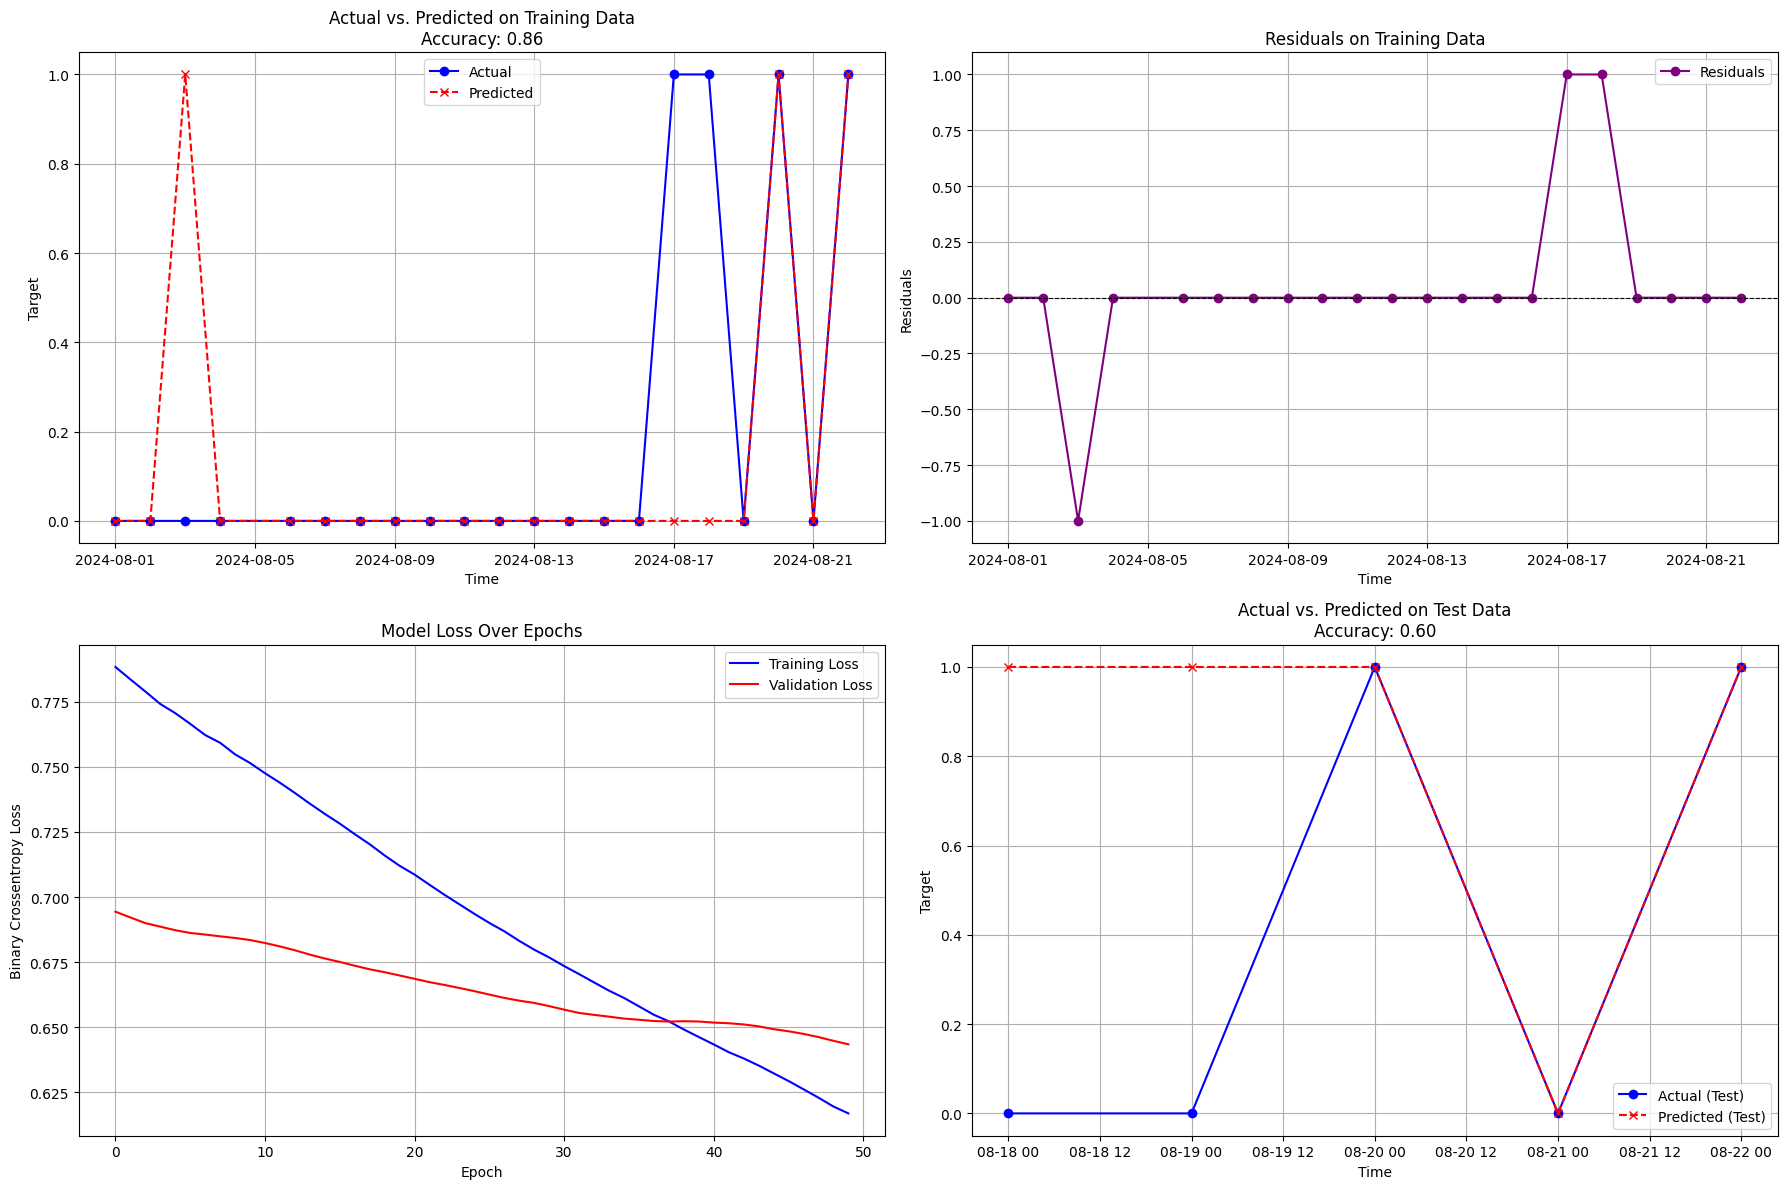

In [ ]:
#@title Grafici Modello DPL

# Create a 2x2 grid of plots
fig, axs = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Actual vs. Predicted on Training Data
axs[0, 0].plot(y_train.index, y_train_bin, label='Actual', color='blue', marker='o')
axs[0, 0].plot(y_train.index, y_train_pred, label='Predicted', color='red', linestyle='--', marker='x')
axs[0, 0].set_title(f'Actual vs. Predicted on Training Data\nAccuracy: {accuracy_train:.2f}')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Target')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot 2: Residuals on Training Data
residuals_train = y_train_bin - y_train_pred
axs[0, 1].plot(y_train.index, residuals_train, label='Residuals', color='purple', marker='o')
axs[0, 1].axhline(0, color='black', linewidth=0.8, linestyle='--')
axs[0, 1].set_title('Residuals on Training Data')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Residuals')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot 3: Training & Validation Loss Over Epochs
axs[1, 0].plot(history.history['loss'], label='Training Loss', color='blue')
axs[1, 0].plot(history.history['val_loss'], label='Validation Loss', color='red')
axs[1, 0].set_title('Model Loss Over Epochs')
axs[1, 0].set_ylabel('Binary Crossentropy Loss')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Plot 4: Actual vs. Predicted on Test Data
axs[1, 1].plot(y_test.index, y_test_bin, label='Actual (Test)', marker='o', color='blue')
axs[1, 1].plot(y_test.index, y_test_pred, label='Predicted (Test)', linestyle='--', marker='x', color='red')
axs[1, 1].set_title(f'Actual vs. Predicted on Test Data\nAccuracy: {accuracy_test:.2f}')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Target')
axs[1, 1].legend()
axs[1, 1].grid(True)

# Show the plots
plt.tight_layout()
plt.show()


In [ ]:
model_binary.save('trained_mlp.h5')

In [ ]:
#@title Model Optimization: Cross Validation
from tensorflow.keras.models import load_model
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# 1. Caricamento del modello salvato
model_binary = load_model('trained_mlp.h5')

# 2. Recupero delle dimensioni delle feature originali
input_dim = model_binary.input_shape[1]  # Numero di feature atteso dal modello
df_copia = df_finale_2.copy()
# 3. Preprocessing dei dati: crea le feature lagged
n_lags = 1
lagged_df = create_lagged_features(df_copia, n_lags=n_lags, target_col='Nuove catture (per evento)', exog_cols=exog_cols)

# Definizione delle feature e del target
feature_cols = [f'lag_{i}' for i in range(1, n_lags + 1)] + exog_cols
X = lagged_df[feature_cols]
y = lagged_df['Nuove catture (per evento)']

# Binarizzazione del target
y_bin = (y >= 1).astype(int)

# 4. Scaling delle feature
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5. Cross-Validation con KFold
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Salva i pesi originali del modello per riutilizzarli in ogni fold
initial_weights = model_binary.get_weights()

# Variabili per tracciare i risultati
rmse_scores = []
mae_scores = []
accuracies = []

# Itera sui fold
fold = 1
for train_index, val_index in kf.split(X_scaled):
    print(f"Fold {fold}")

    # Dividi i dati in training e validation
    X_train_cv, X_val_cv = X_scaled[train_index], X_scaled[val_index]
    y_train_cv, y_val_cv = y_bin.iloc[train_index], y_bin.iloc[val_index]

    # Ripristina i pesi originali del modello
    model_binary.set_weights(initial_weights)

    # Ricompila il modello
    model_binary.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    pesi_loss = {0: 1, 1: 2}
    # Addestra il modello
    history = model_binary.fit(
        X_train_cv, y_train_cv,
        epochs=20,
        batch_size=16,
        validation_data=(X_val_cv, y_val_cv),
        verbose=0,
        class_weight=pesi_loss
    )

    # Predizioni sul validation set
    y_val_pred_probs = model_binary.predict(X_val_cv)
    y_val_pred = (y_val_pred_probs >= 0.5).astype(int).flatten()

    # Calcola le metriche
    rmse = np.sqrt(mean_squared_error(y_val_cv, y_val_pred))
    mae = mean_absolute_error(y_val_cv, y_val_pred)
    accuracy = accuracy_score(y_val_cv, y_val_pred)

    rmse_scores.append(rmse)
    mae_scores.append(mae)
    accuracies.append(accuracy)

    print(f"Fold {fold} - RMSE: {rmse:.4f}, MAE: {mae:.4f}, Accuracy: {accuracy:.4f}")
    fold += 1

# Calcola la media delle metriche
avg_rmse = np.mean(rmse_scores)
avg_mae = np.mean(mae_scores)
avg_accuracy = np.mean(accuracies)

print(f"\nAverage RMSE: {avg_rmse:.4f}")
print(f"Average MAE: {avg_mae:.4f}")
print(f"Average Accuracy: {avg_accuracy:.4f}")


Fold 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Fold 1 - RMSE: 0.6325, MAE: 0.4000, Accuracy: 0.6000
Fold 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Fold 2 - RMSE: 0.5000, MAE: 0.2500, Accuracy: 0.7500
Fold 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Fold 3 - RMSE: 0.5000, MAE: 0.2500, Accuracy: 0.7500
Fold 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Fold 4 - RMSE: 0.0000, MAE: 0.0000, Accuracy: 1.0000
Fold 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Fold 5 - RMSE: 0.0000, MAE: 0.0000, Accuracy: 1.0000

Average RMSE: 0.3265
Average MAE: 0.1800
Average Accuracy: 0.8200



Average RMSE: 0.3265
Average MAE: 0.1800
Average Accuracy: 0.8200


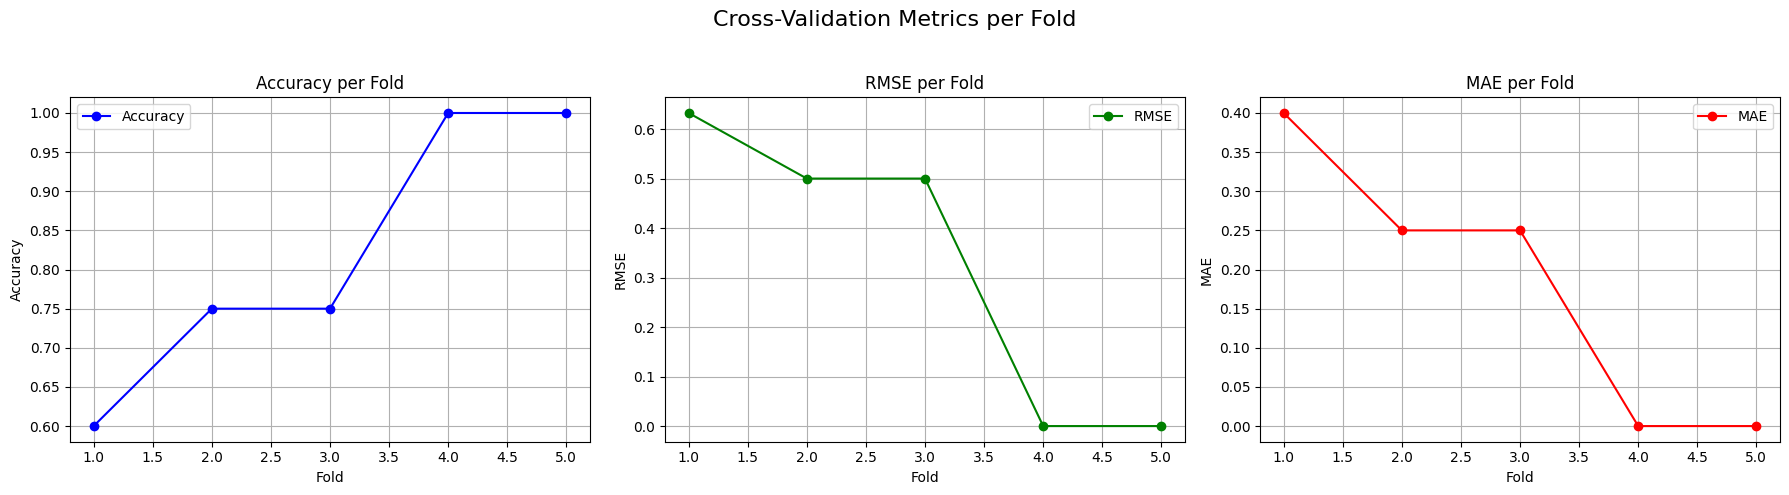

In [ ]:

# Calcolo delle medie delle metriche
avg_rmse = np.mean(rmse_scores)
avg_mae = np.mean(mae_scores)
avg_accuracy = np.mean(accuracies)

print(f"\nAverage RMSE: {avg_rmse:.4f}")
print(f"Average MAE: {avg_mae:.4f}")
print(f"Average Accuracy: {avg_accuracy:.4f}")

# Creazione del grafico delle metriche per ogni fold
folds = range(1, k + 1)

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Accuracy per fold
ax[0].plot(folds, accuracies, marker='o', label='Accuracy', color='blue')
ax[0].set_title('Accuracy per Fold')
ax[0].set_xlabel('Fold')
ax[0].set_ylabel('Accuracy')
ax[0].grid(True)
ax[0].legend()

# RMSE per fold
ax[1].plot(folds, rmse_scores, marker='o', label='RMSE', color='green')
ax[1].set_title('RMSE per Fold')
ax[1].set_xlabel('Fold')
ax[1].set_ylabel('RMSE')
ax[1].grid(True)
ax[1].legend()

# MAE per fold
ax[2].plot(folds, mae_scores, marker='o', label='MAE', color='red')
ax[2].set_title('MAE per Fold')
ax[2].set_xlabel('Fold')
ax[2].set_ylabel('MAE')
ax[2].grid(True)
ax[2].legend()

plt.suptitle('Cross-Validation Metrics per Fold', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Test Dataset Metrics:
RMSE: 0.4472
MAE: 0.2000
Accuracy: 0.8000


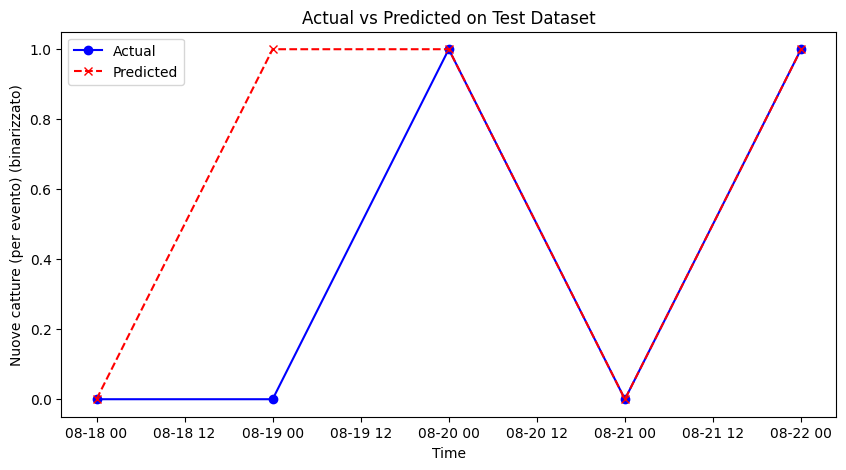

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
import numpy as np


# Creazione delle feature lagged
new_df = df_test_2.copy()
new_lagged_df = create_lagged_features(new_df, n_lags=n_lags, target_col='Nuove catture (per evento)', exog_cols=exog_cols)

# Definizione delle feature e del target
X_new = new_lagged_df[feature_cols]
y_new = new_lagged_df['Nuove catture (per evento)']

# Binarizzazione del target (se necessario)
y_new_bin = (y_new >= 1).astype(int)

# Scaling delle feature usando lo stesso scaler
X_new_scaled = scaler.transform(X_new)

# 2. Predizione sul nuovo dataset
y_new_pred_probs = model_binary.predict(X_new_scaled)
y_new_pred = (y_new_pred_probs >= 0.5).astype(int).flatten()

# 3. Calcolo delle metriche
rmse_new = np.sqrt(mean_squared_error(y_new_bin, y_new_pred))
mae_new = mean_absolute_error(y_new_bin, y_new_pred)
accuracy_new = accuracy_score(y_new_bin, y_new_pred)

print(f"Test Dataset Metrics:")
print(f"RMSE: {rmse_new:.4f}")
print(f"MAE: {mae_new:.4f}")
print(f"Accuracy: {accuracy_new:.4f}")

# 4. Visualizzazione dei risultati
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(y_new.index, y_new_bin, label='Actual', marker='o', color='blue')
plt.plot(y_new.index, y_new_pred, label='Predicted', linestyle='--', marker='x', color='red')
plt.title('Actual vs Predicted on Test Dataset')
plt.xlabel('Time')
plt.ylabel('Nuove catture (per evento) (binarizzato)')
plt.legend()
plt.show()
